## Welcome! I am your Kaggle Real Estate Agent in Ames, Iowa.

This is my second notebook upload, or lets say challenge, to Kaggle Competitions. Hope you enjoy!

Before we start, I believe that this notebook will help you to see how a regression problem can be handled from scratch. We will cover some common steps and try to make heuristic comments. 

If you feel overwhelmed with python implementations, you can check Python Data Science Handbook by Jake VanderPlas.<br> Here: https://jakevdp.github.io/PythonDataScienceHandbook/

Let's dive into the challenge. We have a **regression problem** for House Prices and our evaluation metric is **Root Mean Square Error (RMSE)** as mentioned in the competition description. My objective is to use tree-based ML algorithms which are **Random Forest(RF), Gradient Boosting, Extreme Gradient Boosting(XGB), Light Gradient Boosting Machine(LGBM), and CatBoost** as baseline models. Then we will tune the parameters of XGB and CatBoost by using Randomized Search. Finally, we will get the final predictions for our houses.

Moreover, since we optimized 2 models, XGB and CatBoost, we will also average the results in the last step.

We will go through some common steps:<br>
1) [Preparing libraries and data](#1)<br>
2) [Explatory data analysis(EDA)](#2)<br>
3) [Preprocess the data](#3)<br>
4) [Model selection and hyperparameter search](#4)<br>
5) [Final prediction and export](#5)<br>
6) [Additional: averaging models](#6)

I will give brief explanations for each step. If you have any questions, please let me know :)  

# 1) Preparing Libraries and Data

In [1]:
# Common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from scipy.stats import norm, skew 

# Preprocess libraries
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, StandardScaler, PowerTransformer, FunctionTransformer # for scaling
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold # for hyperparameter search

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error #evaluation metric

# Tree Based Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor

plt.style.use('ggplot') 
color_pal = sns.color_palette()

In [2]:
# Obtain Data
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df.drop_duplicates()
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Notes on investigating the data 
Before EDA part, we should learn the variables and derive some facts from the data. First, let's give an brief introduction of the data by investigating the shape, numerical&categorical variables, missing values, distribution of the target, and sparsity. Our aim is **to reduce the number of variables without losing information about the target** by looking at their missing percentage, sparsity level, and effectiveness on the target (for example "id" variable may not be related to the target.) 

Lets review:
 * Describing variables
 * Missing values
 * Distribution of the target variable
 * Zero or near-zero variance variables
 * Numerical and categorical variables
 * Variable descriptions from the competition

In [3]:
# Brief Introduction of Data
print("---------------Train Dataset Shape---------------")
display(df.shape)
print("---------------Describing Numerical Variables---------------")
display(df.describe(exclude="object").T)
print("---------------Describing Categorical Variables---------------")
display(df.describe(include="object").T)
print("---------------Feature Information---------------")
display(df.info())
print("---------------Missing Value Percentage---------------")
display(pd.DataFrame(df.isnull().sum()/df.shape[0], columns=["null_percent"]).query('null_percent > 0').round(4).sort_values("null_percent", ascending=False)*100)

---------------Train Dataset Shape---------------


(1460, 81)

---------------Describing Numerical Variables---------------


,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


---------------Describing Categorical Variables---------------


,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


---------------Feature Information---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  Ov

None

---------------Missing Value Percentage---------------


,null_percent
PoolQC,99.52
MiscFeature,96.30
Alley,93.77
Fence,80.75
FireplaceQu,47.26
LotFrontage,17.74
GarageType,5.55
GarageYrBlt,5.55
GarageFinish,5.55
GarageQual,5.55


Since we have a regression problem, lets have a quick check on the target. It is a good practice to have a normally distributed target for many models and statistical asssumptions. In case of non-normality, we can use transformations such as log transformation. We will also transform the numerical variables in the preprocessing step.

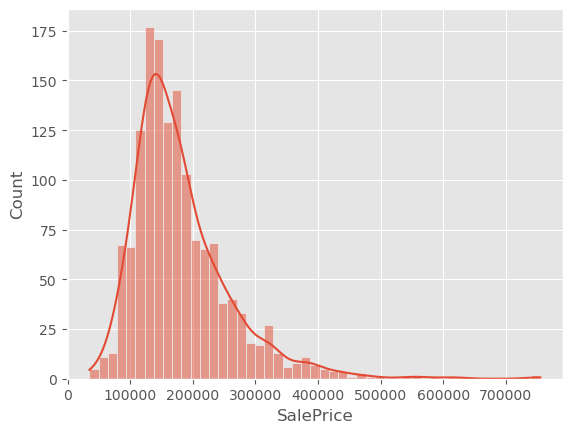

In [4]:
# Target variable distribution
# Since px library is interactive, it does not show the graph until you run.
# px.histogram(df['SalePrice'],marginal='box')

sns.histplot(data=df['SalePrice'], kde=True)
plt.show()

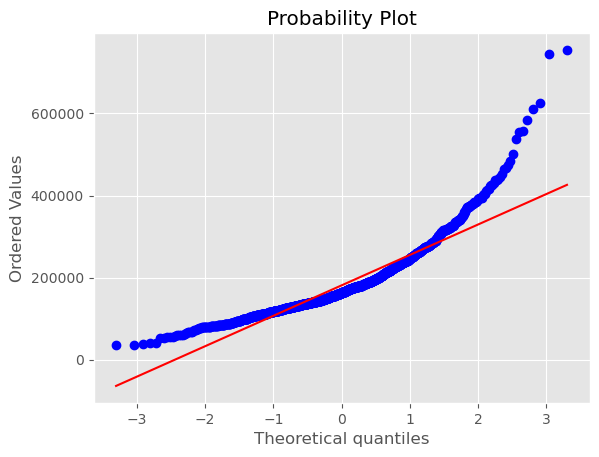

Skewness of SalePrice is : 1.88 which is right-skewed. Lets use log transformation to handle skewness.


In [5]:
# QQ-Plot for the target
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show()
print(f"Skewness of SalePrice is : {skew(df['SalePrice']):.2f} which is right-skewed. Lets use log transformation to handle skewness.")

Skewness of SalePrice after the transformation is : 0.12


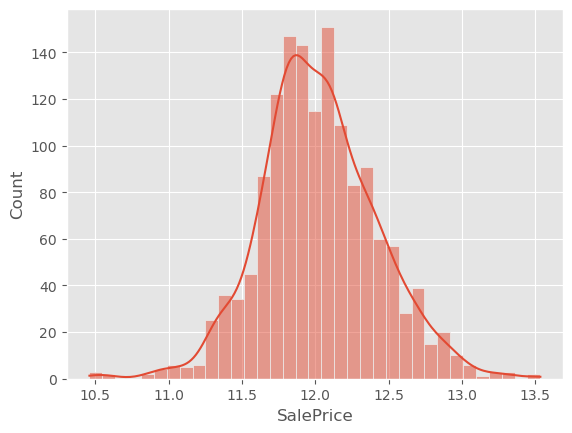

In [6]:
# Target variable distribution
print(f"Skewness of SalePrice after the transformation is : {skew(np.log1p(df['SalePrice'])):.2f}")
# px.histogram(np.log1p(df["SalePrice"]),marginal='box')

sns.histplot(data=np.log1p(df["SalePrice"]), kde=True)
plt.show()

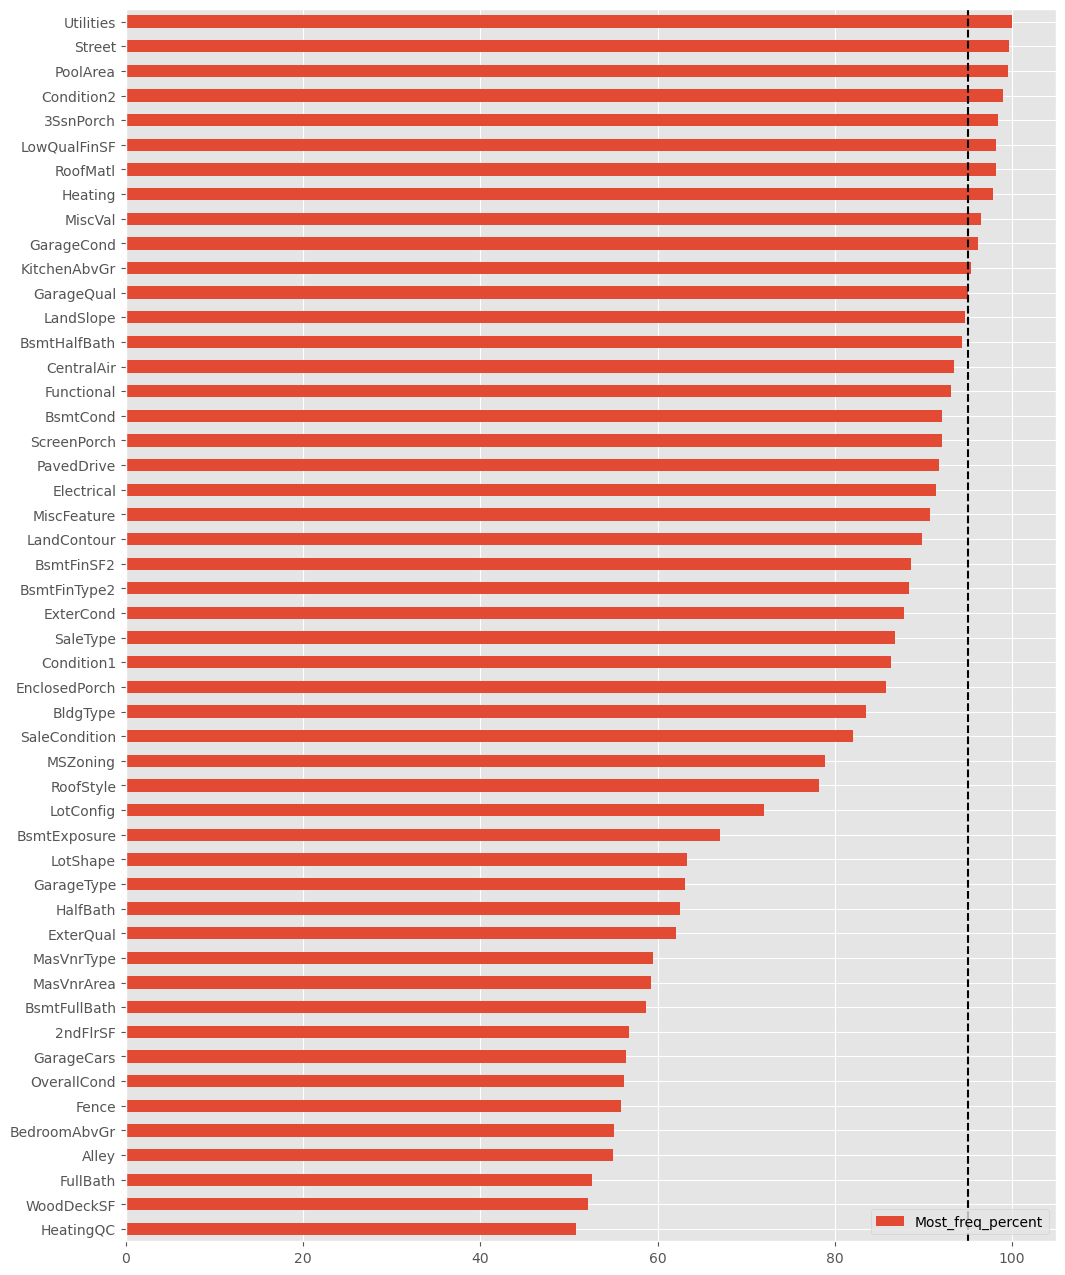

In [7]:
# for all variables, most frequent value percent to check variance level (zero or near-zero variance).
most_freq_percent = {}
for col in df.columns: #.select_dtypes(exclude="object")
    most_freq_percent[col] = df[[col]].value_counts().iloc[0]/df[[col]].count().iloc[0]*100
df_most_freq = pd.DataFrame.from_dict(most_freq_percent, orient='index',columns=["Most_freq_percent"]).round(2)
ax = df_most_freq.sort_values("Most_freq_percent", ascending=True).tail(50).plot(kind="barh", figsize=(12,16))
ax.axvline(95, color="black", ls="--")
plt.show()

In [8]:
# These variables can be listed as near-zero variance and they may be removed depending on the problem.
df_most_freq.sort_values("Most_freq_percent", ascending=False).query('Most_freq_percent>94')

,Most_freq_percent
Utilities,99.93
Street,99.59
PoolArea,99.52
Condition2,98.97
3SsnPorch,98.36
RoofMatl,98.22
LowQualFinSF,98.22
Heating,97.81
MiscVal,96.44
GarageCond,96.16


When we look at the dataset description from the competition page, some variables are required to be processed. Some processes are listed below,

 * Find ordinal variables and order them instead of onehotencoding them.
 * Search notes in the description to deal with missing values. For example, some missing values can be filled with a new class like "N/A" or "OTHER" instead of imputation.
 * To deal with near-zero variance, we can either use feature selection methods like VarianceThreshold or set a cutoff level to merge the classes below the cutoff into a "Other" class. Both of them are optional, because it may cause some problems. Moreover, it can cause information loss but improve the computation performance. 
 * We can calculate "Age" variable instead of using "Year" variables.  

The dataset variables and notes are given in the table below.

| #  | Variable      | Description                                                                                        | Data Type             | Count | Missing % | Mean     | Min   | Max    | Most frequent % | Note                                                    |
|----|---------------|----------------------------------------------------------------------------------------------------|-----------------------|-------|-----------|----------|-------|--------|-----------------|---------------------------------------------------------|
| 1  | Id            | ID                                                                                                 | Numerical             | 1460  | 0%        | 730.5    | 1     | 1460   | 0.1%            | It can be dropped.                                      |
| 2  | MSSubClass    | The building class                                                                                 | Categorical - Nominal | 1460  | 0%        | 56.89726 | 20    | 190    | 36.7%           | 15 unique counts, it can be reduced by cutoff function. |
| 3  | LotFrontage   | Linear feet of street connected to property                                                        | Numerical             | 1201  | 18%       | 70.04996 | 21    | 313    | 11.9%           |                                                         |
| 4  | LotArea       | Lot size in square feet                                                                            | Numerical             | 1460  | 0%        | 10516.83 | 1300  | 215245 | 1.7%            |                                                         |
| 5  | OverallQual   | Overall material and finish quality                                                                | Numerical             | 1460  | 0%        | 6.099315 | 1     | 10     | 27.2%           | It can be processed like Categorical - Ordinal          |
| 6  | OverallCond   | Overall condition rating                                                                           | Numerical             | 1460  | 0%        | 5.575342 | 1     | 9      | 56.2%           | It can be processed like Categorical - Ordinal          |
| 7  | YearBuilt     | Original construction date                                                                         | Numerical             | 1460  | 0%        | 1971.268 | 1872  | 2010   | 4.6%            | Age can be calculated.                                  |
| 8  | YearRemodAdd  | Remodel date                                                                                       | Numerical             | 1460  | 0%        | 1984.866 | 1950  | 2010   | 12.2%           | Age can be calculated.                                  |
| 9  | MasVnrArea    | Masonry veneer area in square feet                                                                 | Numerical             | 1452  | 1%        | 103.6853 | 0     | 1600   | 59.3%           |                                                         |
| 10 | BsmtFinSF1    | Type 1 finished square feet                                                                        | Numerical             | 1460  | 0%        | 443.6397 | 0     | 5644   | 32.0%           |                                                         |
| 11 | BsmtFinSF2    | Type 2 finished square feet                                                                        | Numerical             | 1460  | 0%        | 46.54932 | 0     | 1474   | 88.6%           |                                                         |
| 12 | BsmtUnfSF     | Unfinished square feet of basement area                                                            | Numerical             | 1460  | 0%        | 567.2404 | 0     | 2336   | 8.1%            |                                                         |
| 13 | TotalBsmtSF   | Total square feet of basement area                                                                 | Numerical             | 1460  | 0%        | 1057.429 | 0     | 6110   | 2.5%            |                                                         |
| 14 | 1stFlrSF      | First Floor square feet                                                                            | Numerical             | 1460  | 0%        | 1162.627 | 334   | 4692   | 1.7%            |                                                         |
| 15 | 2ndFlrSF      | Second Floor square feet                                                                           | Numerical             | 1460  | 0%        | 346.9925 | 0     | 2065   | 56.8%           |                                                         |
| 16 | LowQualFinSF  | Low quality finished square feet (all floors)                                                      | Numerical             | 1460  | 0%        | 5.844521 | 0     | 572    | 98.2%           | It can be handled as near zero variance                 |
| 17 | GrLivArea     | Above grade (ground) living area square feet                                                       | Numerical             | 1460  | 0%        | 1515.464 | 334   | 5642   | 1.5%            |                                                         |
| 18 | BsmtFullBath  | Basement full bathrooms                                                                            | Numerical             | 1460  | 0%        | 0.425342 | 0     | 3      | 58.6%           | It can be processed like Categorical - Ordinal          |
| 19 | BsmtHalfBath  | Basement half bathrooms                                                                            | Numerical             | 1460  | 0%        | 0.057534 | 0     | 2      | 94.4%           | It can be handled as near zero variance                 |
| 20 | FullBath      | Full bathrooms above grade                                                                         | Numerical             | 1460  | 0%        | 1.565068 | 0     | 3      | 52.6%           | It can be processed like Categorical - Ordinal          |
| 21 | HalfBath      | Half baths above grade                                                                             | Numerical             | 1460  | 0%        | 0.382877 | 0     | 2      | 62.5%           | It can be processed like Categorical - Ordinal          |
| 22 | BedroomAbvGr  | Bedrooms above grade                                                                               | Numerical             | 1460  | 0%        | 2.866438 | 0     | 8      | 55.1%           | It can be processed like Categorical - Ordinal          |
| 23 | KitchenAbvGr  | Kitchens above grade                                                                               | Numerical             | 1460  | 0%        | 1.046575 | 0     | 3      | 95.3%           | It can be handled as near zero variance                 |
| 24 | TotRmsAbvGrd  | Total rooms above grade (does not include bathrooms)                                               | Numerical             | 1460  | 0%        | 6.517808 | 2     | 14     | 27.5%           | It can be processed like Categorical - Ordinal          |
| 25 | Fireplaces    | Number of fireplaces                                                                               | Numerical             | 1460  | 0%        | 0.613014 | 0     | 3      | 47.3%           | It can be processed like Categorical - Ordinal          |
| 26 | GarageYrBlt   | Year garage was built                                                                              | Numerical             | 1379  | 6%        | 1978.506 | 1900  | 2010   | 4.7%            | Age can be calculated.                                  |
| 27 | GarageCars    | Size of garage in car capacity                                                                     | Numerical             | 1460  | 0%        | 1.767123 | 0     | 4      | 56.4%           | It can be processed like Categorical - Ordinal          |
| 28 | GarageArea    | Size of garage in square feet                                                                      | Numerical             | 1460  | 0%        | 472.9801 | 0     | 1418   | 5.6%            |                                                         |
| 29 | WoodDeckSF    | Wood deck area in square feet                                                                      | Numerical             | 1460  | 0%        | 94.24452 | 0     | 857    | 52.1%           |                                                         |
| 30 | OpenPorchSF   | Open porch area in square feet                                                                     | Numerical             | 1460  | 0%        | 46.66027 | 0     | 547    | 44.9%           |                                                         |
| 31 | EnclosedPorch | Enclosed porch area in square feet                                                                 | Numerical             | 1460  | 0%        | 21.95411 | 0     | 552    | 85.8%           |                                                         |
| 32 | 3SsnPorch     | Three season porch area in square feet                                                             | Numerical             | 1460  | 0%        | 3.409589 | 0     | 508    | 98.4%           | It can be handled as near zero variance                 |
| 33 | ScreenPorch   | Screen porch area in square feet                                                                   | Numerical             | 1460  | 0%        | 15.06096 | 0     | 480    | 92.1%           |                                                         |
| 34 | PoolArea      | Pool area in square feet                                                                           | Numerical             | 1460  | 0%        | 2.758904 | 0     | 738    | 99.5%           | It can be handled as near zero variance                 |
| 35 | MiscVal       | $Value of miscellaneous feature                                                                    | Numerical             | 1460  | 0%        | 43.48904 | 0     | 15500  | 96.4%           | It can be handled as near zero variance                 |
| 36 | MoSold        | Month Sold (MM)                                                                                    | Numerical             | 1460  | 0%        | 6.321918 | 1     | 12     | 17.3%           |                                                         |
| 37 | YrSold        | Year Sold                                                                                          | Numerical             | 1460  | 0%        | 2007.816 | 2006  | 2010   | 23.2%           | Age can be calculated.                                  |
| 38 | SalePrice     | the property's sale price in dollars. This is the target variable that   you're trying to predict. | Numerical             | 1460  | 0%        | 180921.2 | 34900 | 755000 | 1.4%            |                                                         |

| #  | Variable      | Description                                                         | Data Type             | Count | Missing % | Unique | Top     | Frequency | Most frequent % | Note                                          |
|----|---------------|---------------------------------------------------------------------|-----------------------|-------|-----------|--------|---------|-----------|-----------------|-----------------------------------------------|
| 39 | MSZoning      | The general zoning classification                                   | Categorical - Nominal | 1460  | 0%        | 5      | RL      | 1151      | 78.8%           | It can be reduced by cutoff function.         |
| 40 | Street        | Type of road access to property                                     | Categorical - Nominal | 1460  | 0%        | 2      | Pave    | 1454      | 99.6%           | It can be handled as near zero variance       |
| 41 | Alley         | Type of alley access to property                                    | Categorical - Nominal | 91    | 94%       | 2      | Grvl    | 50        | 54.9%           | It can be dropped.                            |
| 42 | LotShape      | General shape of property                                           | Categorical - Nominal | 1460  | 0%        | 4      | Reg     | 925       | 63.4%           |                                               |
| 43 | LandContour   | Flatness of the property                                            | Categorical - Nominal | 1460  | 0%        | 4      | Lvl     | 1311      | 89.8%           |                                               |
| 44 | Utilities     | Type of utilities available                                         | Categorical - Nominal | 1460  | 0%        | 2      | AllPub  | 1459      | 99.9%           | It can be handled as near zero variance       |
| 45 | LotConfig     | Lot configuration                                                   | Categorical - Nominal | 1460  | 0%        | 5      | Inside  | 1052      | 72.1%           |                                               |
| 46 | LandSlope     | Slope of property                                                   | Categorical - Nominal | 1460  | 0%        | 3      | Gtl     | 1382      | 94.7%           | It can be handled as near zero variance       |
| 47 | Neighborhood  | Physical locations within Ames city limits                          | Categorical - Nominal | 1460  | 0%        | 25     | NAmes   | 225       | 15.4%           | It can be reduced by cutoff function.         |
| 48 | Condition1    | Proximity to various conditions                                     | Categorical - Nominal | 1460  | 0%        | 9      | Norm    | 1260      | 86.3%           | It can be reduced by cutoff function.         |
| 49 | Condition2    | Proximity to various conditions (if more than one is present)       | Categorical - Nominal | 1460  | 0%        | 8      | Norm    | 1445      | 99.0%           | It can be handled as near zero variance       |
| 50 | BldgType      | Type of dwelling                                                    | Categorical - Nominal | 1460  | 0%        | 5      | 1Fam    | 1220      | 83.6%           | It can be reduced by cutoff function.         |
| 51 | HouseStyle    | Style of dwelling                                                   | Categorical - Nominal | 1460  | 0%        | 8      | 1Story  | 726       | 49.7%           | It can be reduced by cutoff function.         |
| 52 | RoofStyle     | Type of roof                                                        | Categorical - Nominal | 1460  | 0%        | 6      | Gable   | 1141      | 78.2%           | It can be reduced by cutoff function.         |
| 53 | RoofMatl      | Roof material                                                       | Categorical - Nominal | 1460  | 0%        | 8      | CompShg | 1434      | 98.2%           | It can be dropped.                            |
| 54 | Exterior1st   | Exterior covering on house                                          | Categorical - Nominal | 1460  | 0%        | 15     | VinylSd | 515       | 35.3%           | It can be reduced by cutoff function.         |
| 55 | Exterior2nd   | Exterior covering on house (if more than one material)              | Categorical - Nominal | 1460  | 0%        | 16     | VinylSd | 504       | 34.5%           |                                               |
| 56 | MasVnrType    | Masonry veneer type                                                 | Categorical - Nominal | 1452  | 1%        | 4      | None    | 864       | 59.5%           | High missing values, it can be imputed.       |
| 57 | ExterQual     | Evaluates the quality of the material on the exterior               | Categorical - Ordinal | 1460  | 0%        | 4      | TA      | 906       | 62.1%           |                                               |
| 58 | ExterCond     | Evaluates the present condition of the material on the exterior     | Categorical - Ordinal | 1460  | 0%        | 5      | TA      | 1282      | 87.8%           |                                               |
| 59 | Foundation    | Type of foundation                                                  | Categorical - Nominal | 1460  | 0%        | 6      | PConc   | 647       | 44.3%           | It can be reduced by cutoff function.         |
| 60 | BsmtQual      | Evaluates the height of the basement                                | Categorical - Ordinal | 1423  | 3%        | 4      | TA      | 649       | 45.6%           |                                               |
| 61 | BsmtCond      | Evaluates the general condition of the basement                     | Categorical - Ordinal | 1423  | 3%        | 4      | TA      | 1311      | 92.1%           |                                               |
| 62 | BsmtExposure  | Refers to walkout or garden level walls                             | Categorical - Ordinal | 1422  | 3%        | 4      | No      | 953       | 67.0%           |                                               |
| 63 | BsmtFinType1  | Rating of basement finished area                                    | Categorical - Ordinal | 1423  | 3%        | 6      | Unf     | 430       | 30.2%           |                                               |
| 64 | BsmtFinType2  | Rating of basement finished area (if multiple types)                | Categorical - Ordinal | 1422  | 3%        | 6      | Unf     | 1256      | 88.3%           |                                               |
| 65 | Heating       | Type of heating                                                     | Categorical - Nominal | 1460  | 0%        | 6      | GasA    | 1428      | 97.8%           | It can be handled as near zero variance       |
| 66 | HeatingQC     | Heating quality and condition                                       | Categorical - Ordinal | 1460  | 0%        | 5      | Ex      | 741       | 50.8%           |                                               |
| 67 | CentralAir    | Central air conditioning                                            | Categorical - Binary  | 1460  | 0%        | 2      | Y       | 1365      | 93.5%           |                                               |
| 68 | Electrical    | Electrical system                                                   | Categorical - Nominal | 1459  | 0%        | 5      | SBrkr   | 1334      | 91.4%           | It can be reduced by cutoff function.         |
| 69 | KitchenQual   | Kitchen quality                                                     | Categorical - Ordinal | 1460  | 0%        | 4      | TA      | 735       | 50.3%           |                                               |
| 70 | Functional    | Home functionality (Assume typical unless deductions are warranted) | Categorical - Nominal | 1460  | 0%        | 7      | Typ     | 1360      | 93.2%           | It can be reduced by cutoff function.         |
| 71 | FireplaceQu   | Fireplace quality                                                   | Categorical - Ordinal | 770   | 47%       | 5      | Gd      | 380       | 49.4%           | Create another category  for   missing values |
| 72 | GarageType    | Garage location                                                     | Categorical - Nominal | 1379  | 6%        | 6      | Attchd  | 870       | 63.1%           | It can be reduced by cutoff function.         |
| 73 | GarageFinish  | Interior finish of the garage                                       | Categorical - Ordinal | 1379  | 6%        | 3      | Unf     | 605       | 43.9%           |                                               |
| 74 | GarageQual    | Garage quality                                                      | Categorical - Ordinal | 1379  | 6%        | 5      | TA      | 1311      | 95.1%           | It can be handled as near zero variance       |
| 75 | GarageCond    | Garage condition                                                    | Categorical - Ordinal | 1379  | 6%        | 5      | TA      | 1326      | 96.2%           | It can be handled as near zero variance       |
| 76 | PavedDrive    | Paved driveway                                                      | Categorical - Ordinal | 1460  | 0%        | 3      | Y       | 1340      | 91.8%           |                                               |
| 77 | PoolQC        | Pool quality                                                        | Categorical - Ordinal | 7     | 100%      | 3      | Gd      | 3         | 42.9%           | It can be dropped.                            |
| 78 | Fence         | Fence quality                                                       | Categorical - Nominal | 281   | 81%       | 4      | MnPrv   | 157       | 55.9%           | Create another category  for   missing values |
| 79 | MiscFeature   | Miscellaneous feature not covered in other categories               | Categorical - Nominal | 54    | 96%       | 4      | Shed    | 49        | 90.7%           | It can be dropped.                            |
| 80 | SaleType      | Type of sale                                                        | Categorical - Nominal | 1460  | 0%        | 9      | WD      | 1267      | 86.8%           | It can be reduced by cutoff function.         |
| 81 | SaleCondition | Condition of sale                                                   | Categorical - Nominal | 1460  | 0%        | 6      | Normal  | 1198      | 82.1%           | It can be reduced by cutoff function.         |

In [9]:
# Lets process the data according to what we have learnt from our investigation.

def preprocess1(df):
    # Drop some variables = near zero + missing values
    drop_list = ["Id","Utilities","Street","PoolArea","Condition2","3SsnPorch","RoofMatl","LowQualFinSF","Heating","MiscVal","GarageCond","KitchenAbvGr","GarageQual","LandSlope","BsmtHalfBath","PoolQC","MiscFeature","Alley"]
    df = df.drop(drop_list,axis=1)
    
    # Handling Ordinal variables (you can also use ordinal encoding methods.)
    dict_quality = {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
    df["BsmtExposure"] = df["BsmtExposure"].fillna(0).replace({"No":1,"Mn":2,"Av":3,"Gd":4})
    df["BsmtFinType1"] = df["BsmtFinType1"].fillna(0).replace({"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6})
    df["BsmtFinType2"] = df["BsmtFinType2"].fillna(0).replace({"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6})
    df["GarageFinish"] = df["GarageFinish"].fillna(0).replace({"Unf":1,"RFn":2,"Fin":3})
    df["PavedDrive"] = df["PavedDrive"].replace({"N":1,"P":2,"Y":3})
    df["CentralAir"] = LabelBinarizer().fit_transform(df["CentralAir"]) #binary transformation    
    
    for i in ["BsmtCond","BsmtQual","FireplaceQu"]: # some variables contain NA class in the description
        df[i] = df[i].fillna(0).replace(dict_quality)
    
    for i in ["ExterQual","ExterCond","HeatingQC","KitchenQual"]:
        df[i] = df[i].replace(dict_quality)


    # Handling Nominal variables
    df["Fence"] = df["Fence"].fillna("N/A") #N/A is given in the description
    df["GarageType"] = df["GarageType"].fillna("N/A") #N/A is given in the description
    df["MSSubClass"] = df["MSSubClass"].apply(lambda x: f'A{x}') #converting into categorical variable
    
    
    # This part is commented out. As mentioned before you can set cutoffs for your categorical variables.
    # In case of computation performance issues, we can use it.
    '''
    def categoricalCutOff(df, var, cutprc=0.06): 
        dict_tmp = {}
        cut = round(df.shape[0] * cutprc,0)
        
        for i in df[var].value_counts().to_frame(name="count").query('count < @cut').index:
            dict_tmp[i] = "Other"
            df[var] = df[var].replace(dict_tmp)
        if df[var].value_counts().shape[0]==2:
            df[var] = LabelBinarizer().fit_transform(df[var].astype("str"))
            

    list_cutoff = ["MSSubClass", "MSZoning","LotShape","LandContour","LotConfig","Condition1",
                   "BldgType","HouseStyle","RoofStyle","Exterior1st","Exterior2nd","MasVnrType","Foundation",
                   "Electrical","Functional","GarageType","SaleType","SaleCondition","Fence"]

    for i in list_cutoff:
        categoricalCutOff(df,i)
    categoricalCutOff(df,"Neighborhood",0.03) # cutoff is changed for the neighborhood
    '''
    
    def yearControl(x,y):
        if y > x:
            return np.nan
        else:
            return y
    
    #YearBuilt, YearRemodAdd, GarageYrBlt can not be higher than YrSold
    df["YearRemodAdd"]=df.apply(lambda x: yearControl(x.YrSold,x.YearRemodAdd), axis=1)
    df["YearBuilt"]=df.apply(lambda x: yearControl(x.YrSold,x.YearBuilt), axis=1)
    df["GarageYrBlt"]=df.apply(lambda x: yearControl(x.YrSold,x.GarageYrBlt), axis=1)

    #age calculation for year columns
    df["BuiltAge"] = df["YrSold"] - df["YearBuilt"] - (df["YearRemodAdd"] - df["YearBuilt"]) 
    df["GarageAge"] = df["YrSold"] - df["GarageYrBlt"]
    df = df.drop(["YearBuilt","YearRemodAdd","GarageYrBlt"],axis=1)
            
    return df

df_drop = preprocess1(df)

# 2) Explatory Data Analysis(EDA)

In this step, we will discover some trends and facts by visualizing the variables. We will try to answer some questions like which neighborhood has the highest sale prices, whether we have outliers in living area square feet or which variables are more related to the sale prices(target).

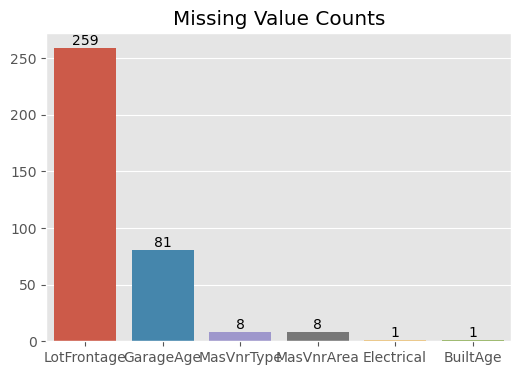

In [10]:
plt.figure(figsize = (6,4))
ax = sns.barplot(x = df_drop.isnull().sum().to_frame(name="count").query('count>0').sort_values("count",ascending=False).index, 
                 y = df_drop.isnull().sum().to_frame(name="count").query('count>0').sort_values("count",ascending=False).values.flatten())
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Missing Value Counts")
plt.show()

### Visualization for Categorical Variables

We will check the distribution and saleprice averages for each categorical variable.

**Important note and question for you:** Ordinal variables are considered as numerical variables to check their correlations among other numerical variables. However, I am not sure whether it is a good practice especially for binary variables like centralair variable. If you have any recommendation or perspective, please let me know in the comment section :) 

In [11]:
list_categorical = df_drop.select_dtypes(include="object").columns.to_list()
print(f"Number of Categorical Variables: {len(list_categorical)}")

Number of Categorical Variables: 20


In [12]:
## categorical var
def CountViz(df):
    ncol = 4 # number of cols in the subplot
    cat_list=list(df.columns)

    plt.figure(figsize = [20, int(np.ceil(len(cat_list)/ncol))*5]) 

    for i in range(len(cat_list)):
        plt.subplot(int(np.ceil(len(cat_list)/ncol)),ncol,i+1)
        ax=sns.countplot(data=df,x=cat_list[i],saturation=0.5)
    
        for p in ax.patches:
            percentage = '{:.0f}%'.format(100 * p.get_height()/df.shape[0])
            x = p.get_x() + p.get_width()/2
            y = p.get_height() *0.5
            ax.annotate(percentage, (x, y),ha='center', size='large', color='darkred', weight='semibold')
    
        plt.xticks(rotation = 45)
        plt.ylabel("")
        plt.xlabel(cat_list[i],fontsize=14)
    plt.tight_layout()
    plt.show()
    

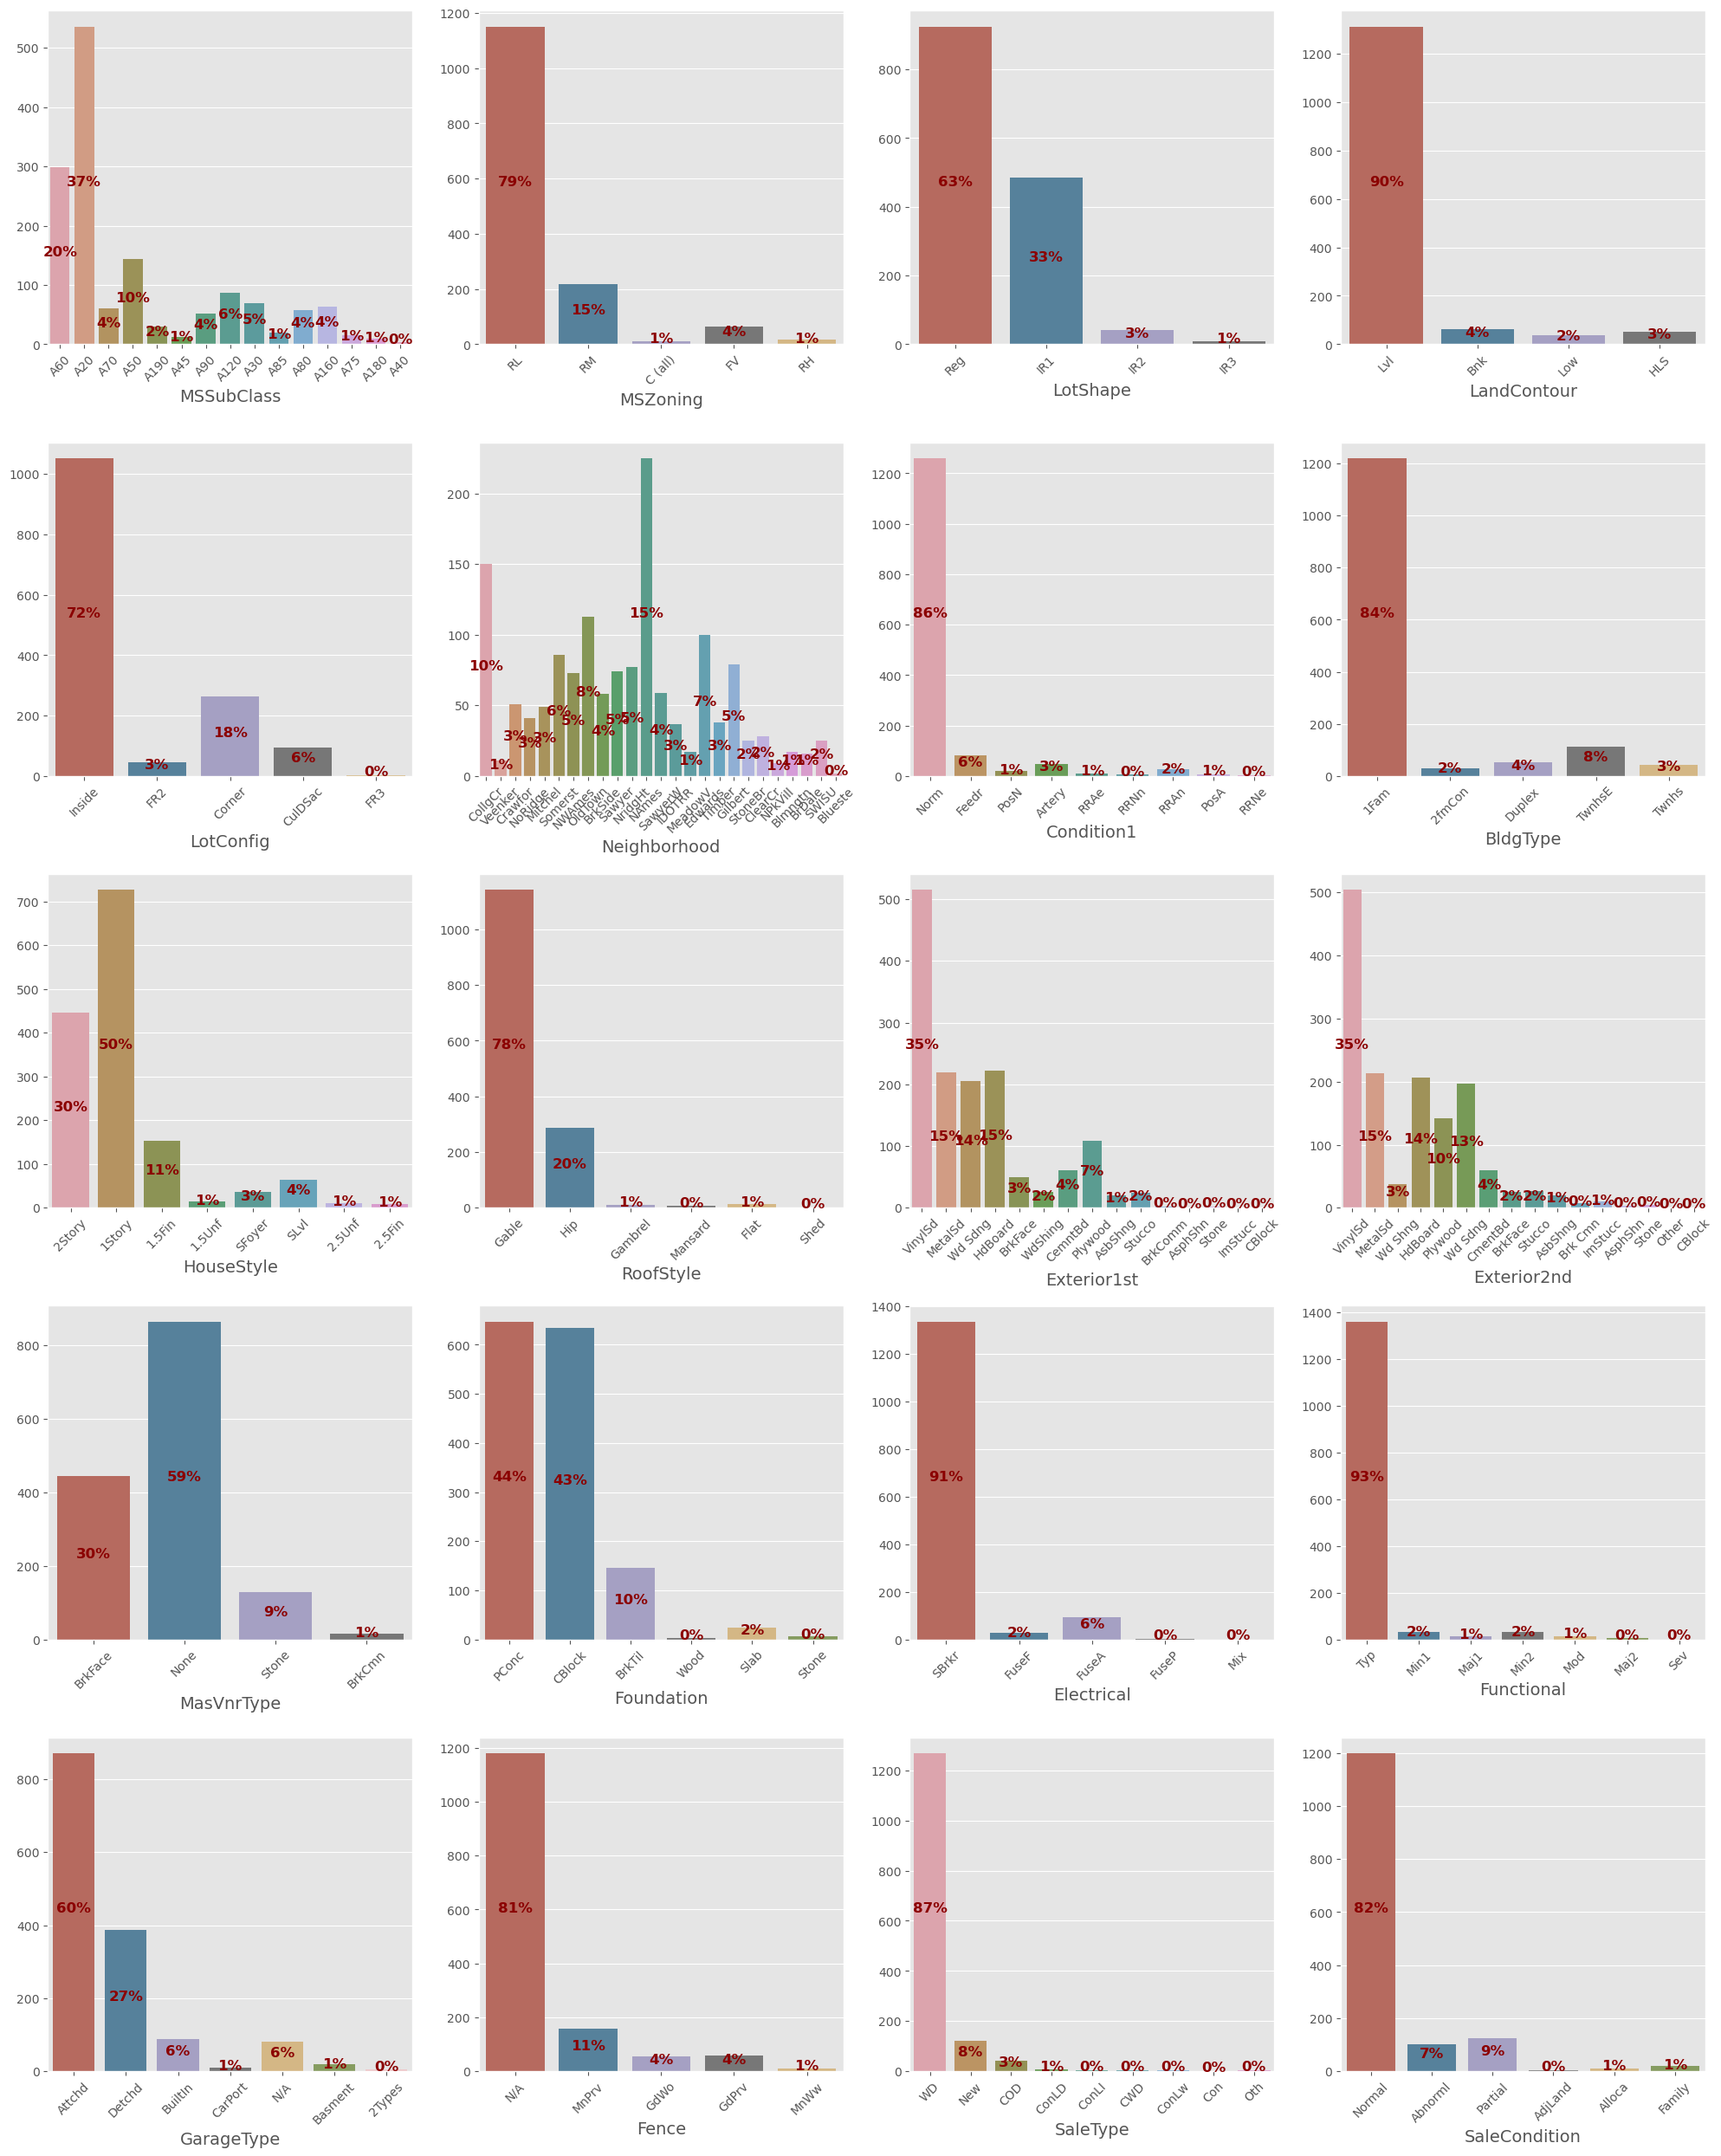

In [13]:
CountViz(df_drop[list_categorical])

In [14]:
# Lets visualize the average sale prices for each categorical variables.
list_categorical2= list_categorical.copy()
list_categorical2.append("SalePrice")

In [15]:
def MeanSalePriceViz(df,target):
    ncol = 4 # number of cols in the subplot
    cat_list=list(df.columns)
    cat_list.remove(target)
    
    plt.figure(figsize = [20, int(np.ceil(len(cat_list)/ncol))*5]) 

    for i in range(len(cat_list)):

        plt.subplot(int(np.ceil(len(cat_list)/ncol)),ncol,i+1)
        ax=sns.barplot(data=df.groupby(cat_list[i]).agg("mean")[target].to_frame().reset_index(),
                       x=cat_list[i],y=target,saturation=0.5)
    
        for p in ax.patches:
            #percentage = '{:.0f}%'.format(100 * p.get_height()/df.shape[0])
            x = p.get_x() + p.get_width()/2
            y = p.get_height() * 0.5
            ax.annotate(round(p.get_height(),None), (x, y),ha='center', size='large', color='darkred',
                        weight='semibold', rotation=90)
    
        plt.xticks(rotation = 45)
        plt.ylabel("")
        plt.xlabel(cat_list[i],fontsize=14)
    plt.tight_layout()
    plt.show()
    

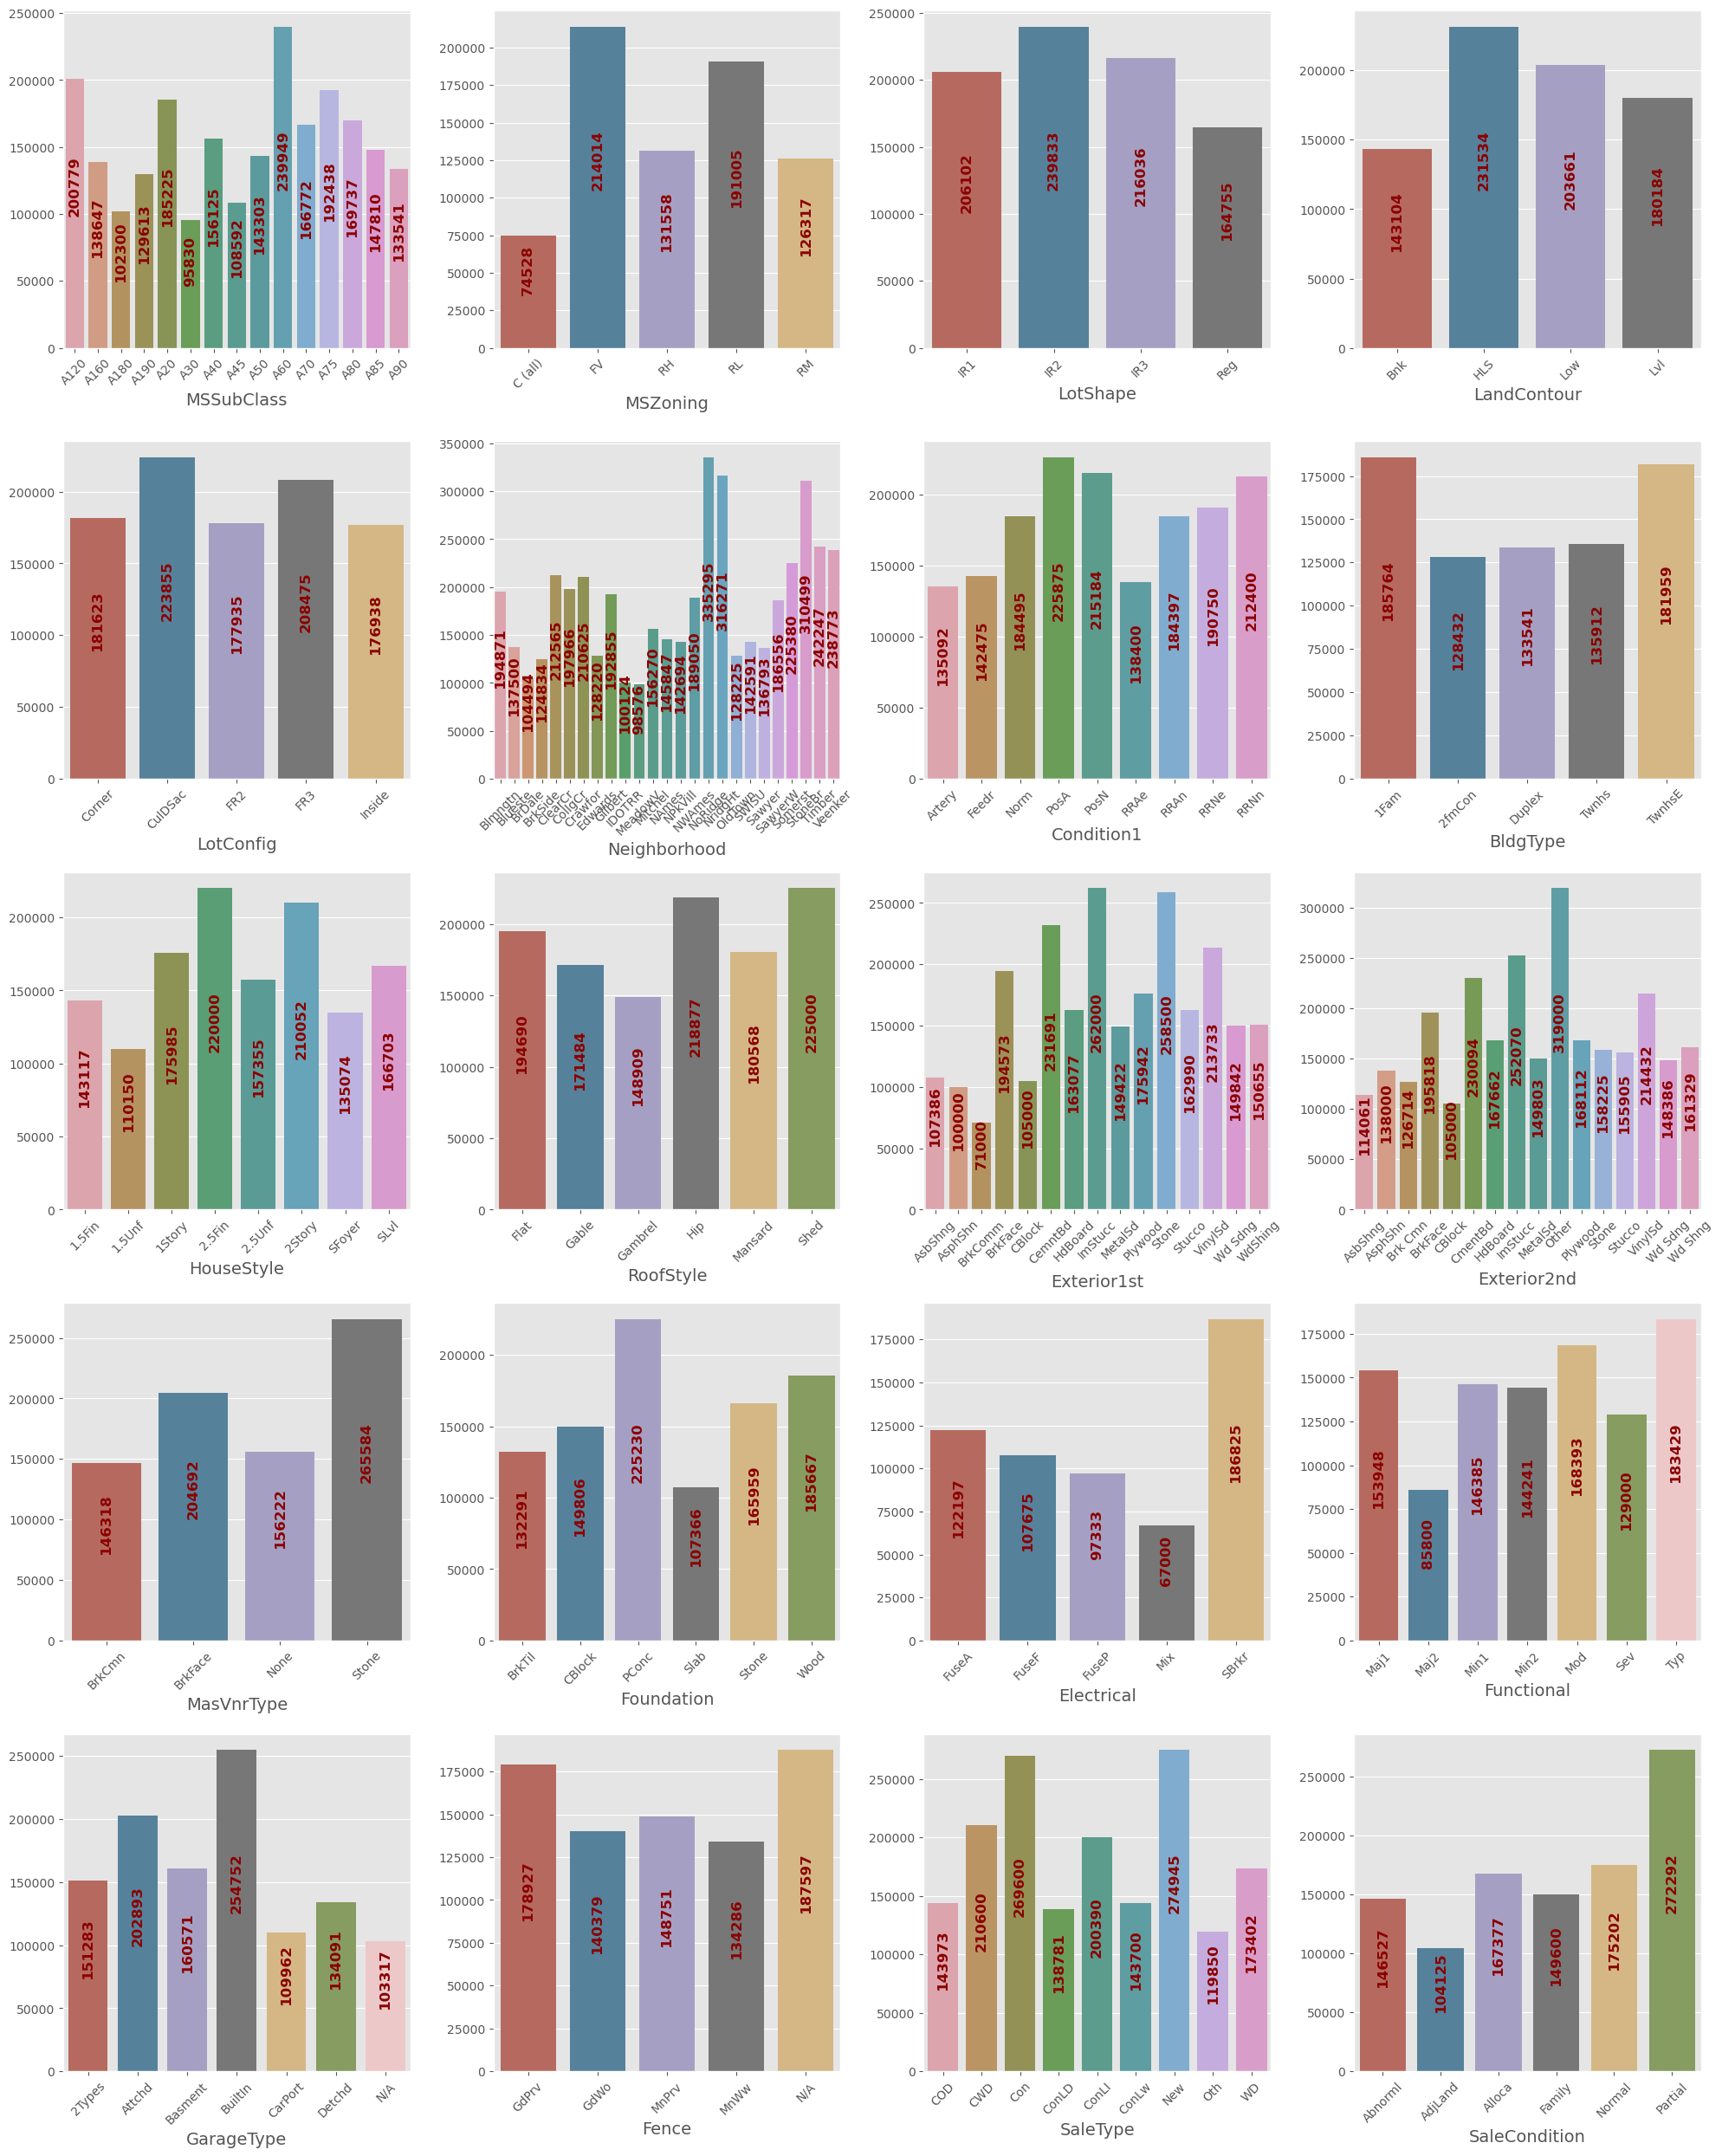

In [16]:
MeanSalePriceViz(df_drop[list_categorical2],"SalePrice")

**Comments:** We can obtain some facts for subcategories by comparing their distribution and sale price averages. Some examples are given below.

 * For Sale Condition (the condition of sale), while "Partial" subcategory constitutes of 9%, it has the highest sale prices comparing to the other subcategories. Tree-based models will take it into the consideration. 
 * For Garage Type, while "BuiltIn" subcategory constitutes of 6%, it has the highest sale prices comparing to the other subcategories.
 * For Fence, while "N/A" subcategory constitutes of 81%, it has the highest sale prices comparing to the other subcategories. So, having a fence may not affect the sale price.

### Visualization for Numerical Variables

Lets perform some analysis to investigate the numerical variables
 * Univariate Analysis by using Boxplots and Histograms
 * Multivariate Analysis by using Heatmap
 * Bivariate Analysis by using Pairplots

### Univariate Analysis - EDA

In [17]:
# viz for numericals
list_numerical = df_drop.select_dtypes(exclude="object").columns.to_list()
print(f"Number of Numerical Variables: {len(list_numerical)}")

Number of Numerical Variables: 42


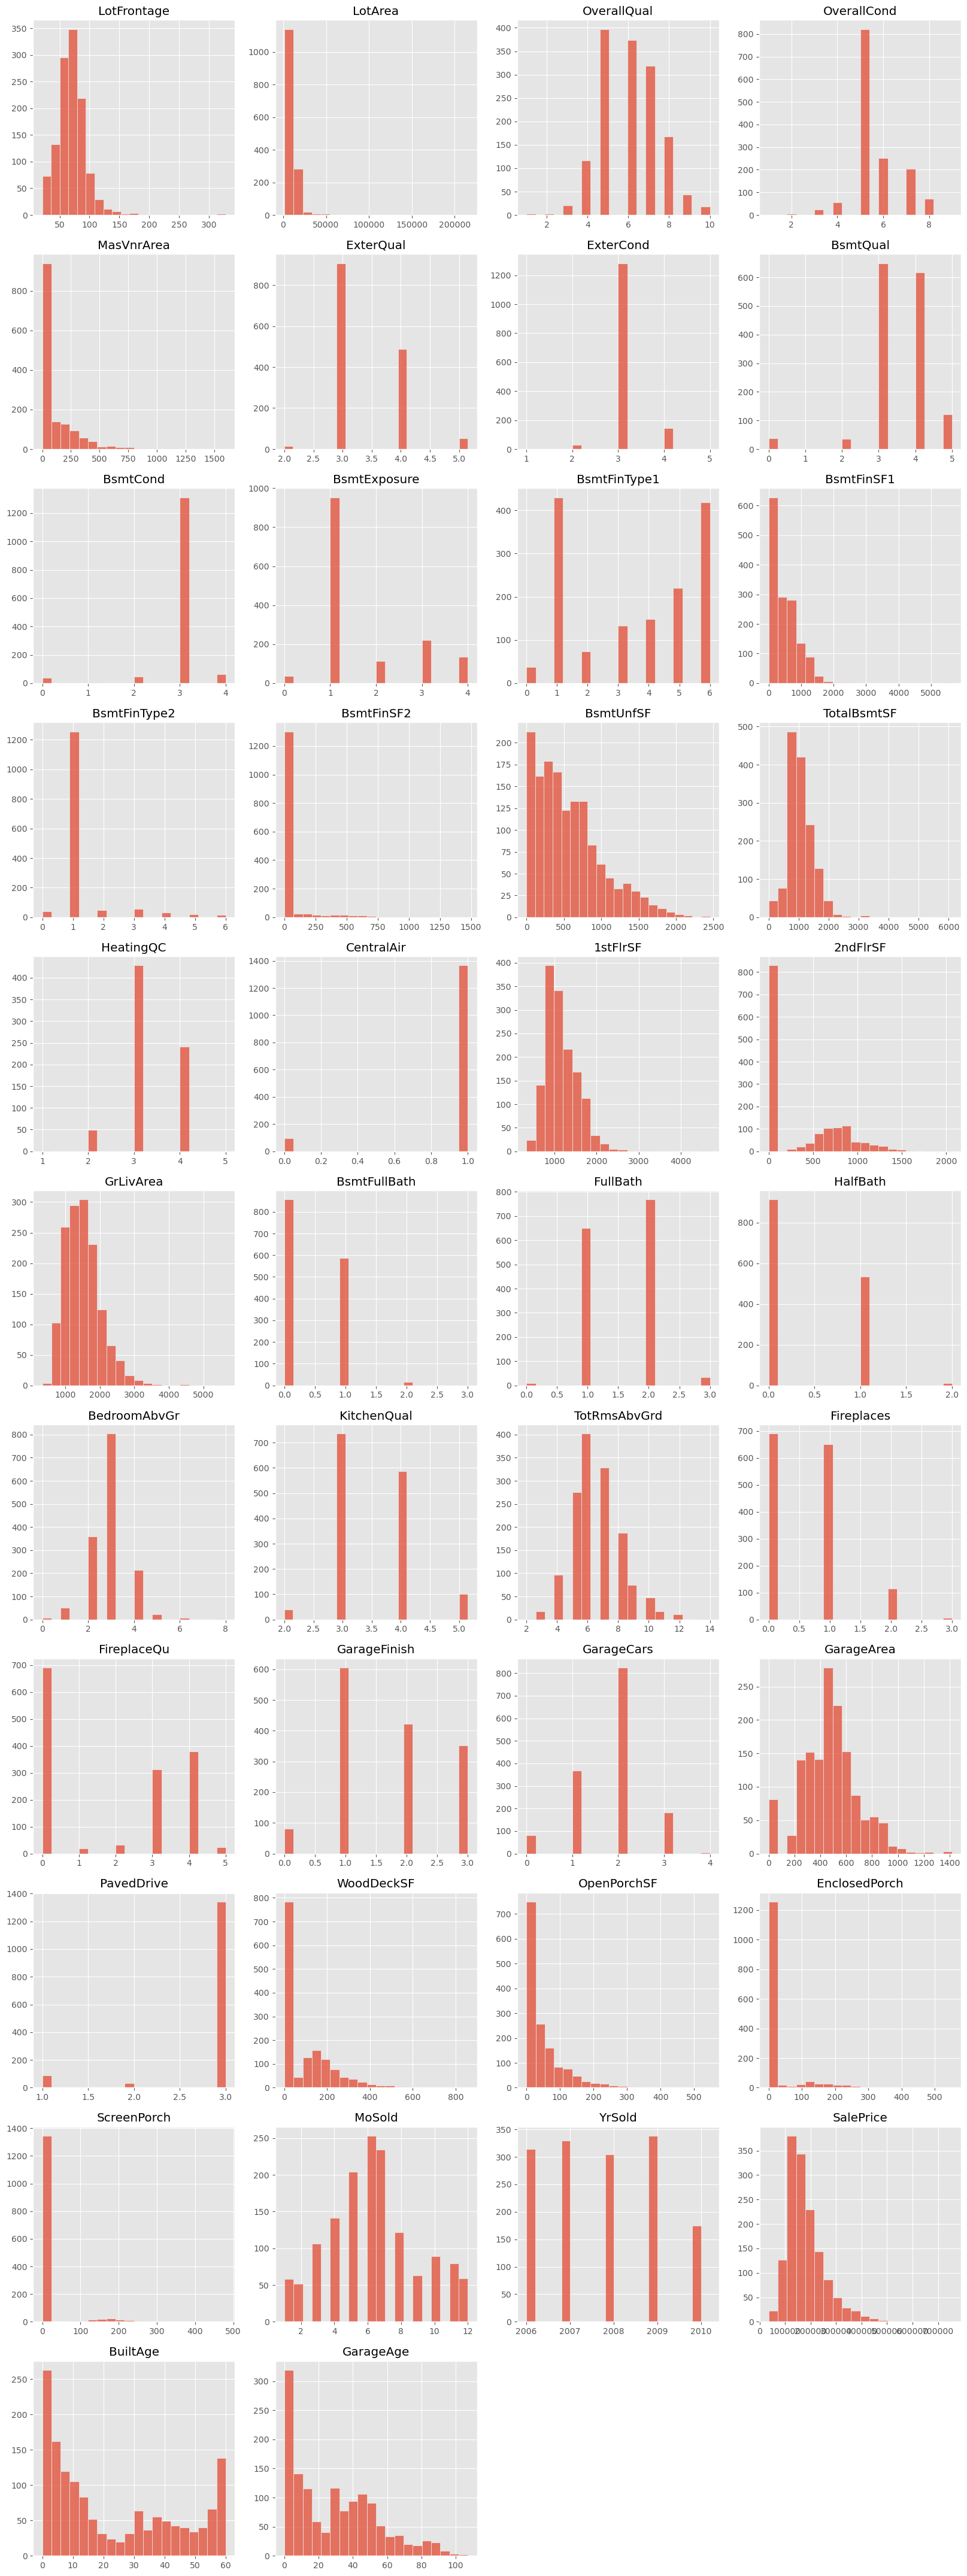

In [18]:
def plot_hist(df,var):
    bw=(df[var].max()-df[var].min())/20
    g = sns.histplot(x = var, data = df, binwidth=bw)
    g.set(xlabel="",ylabel="")
    g.set_title('{}'.format(var))
    
def histViz(df,num_list):
    ncol=4
    plt.figure(figsize = [20, int(np.ceil(len(num_list)/ncol))*5]) 
    plt.tight_layout()    

    for i in range(len(num_list)):
        plt.subplot(int(np.ceil(len(num_list)/ncol)),ncol,i+1)
        plot_hist(df,num_list[i])

    plt.show()
    
histViz(df_drop[list_numerical],list_numerical)

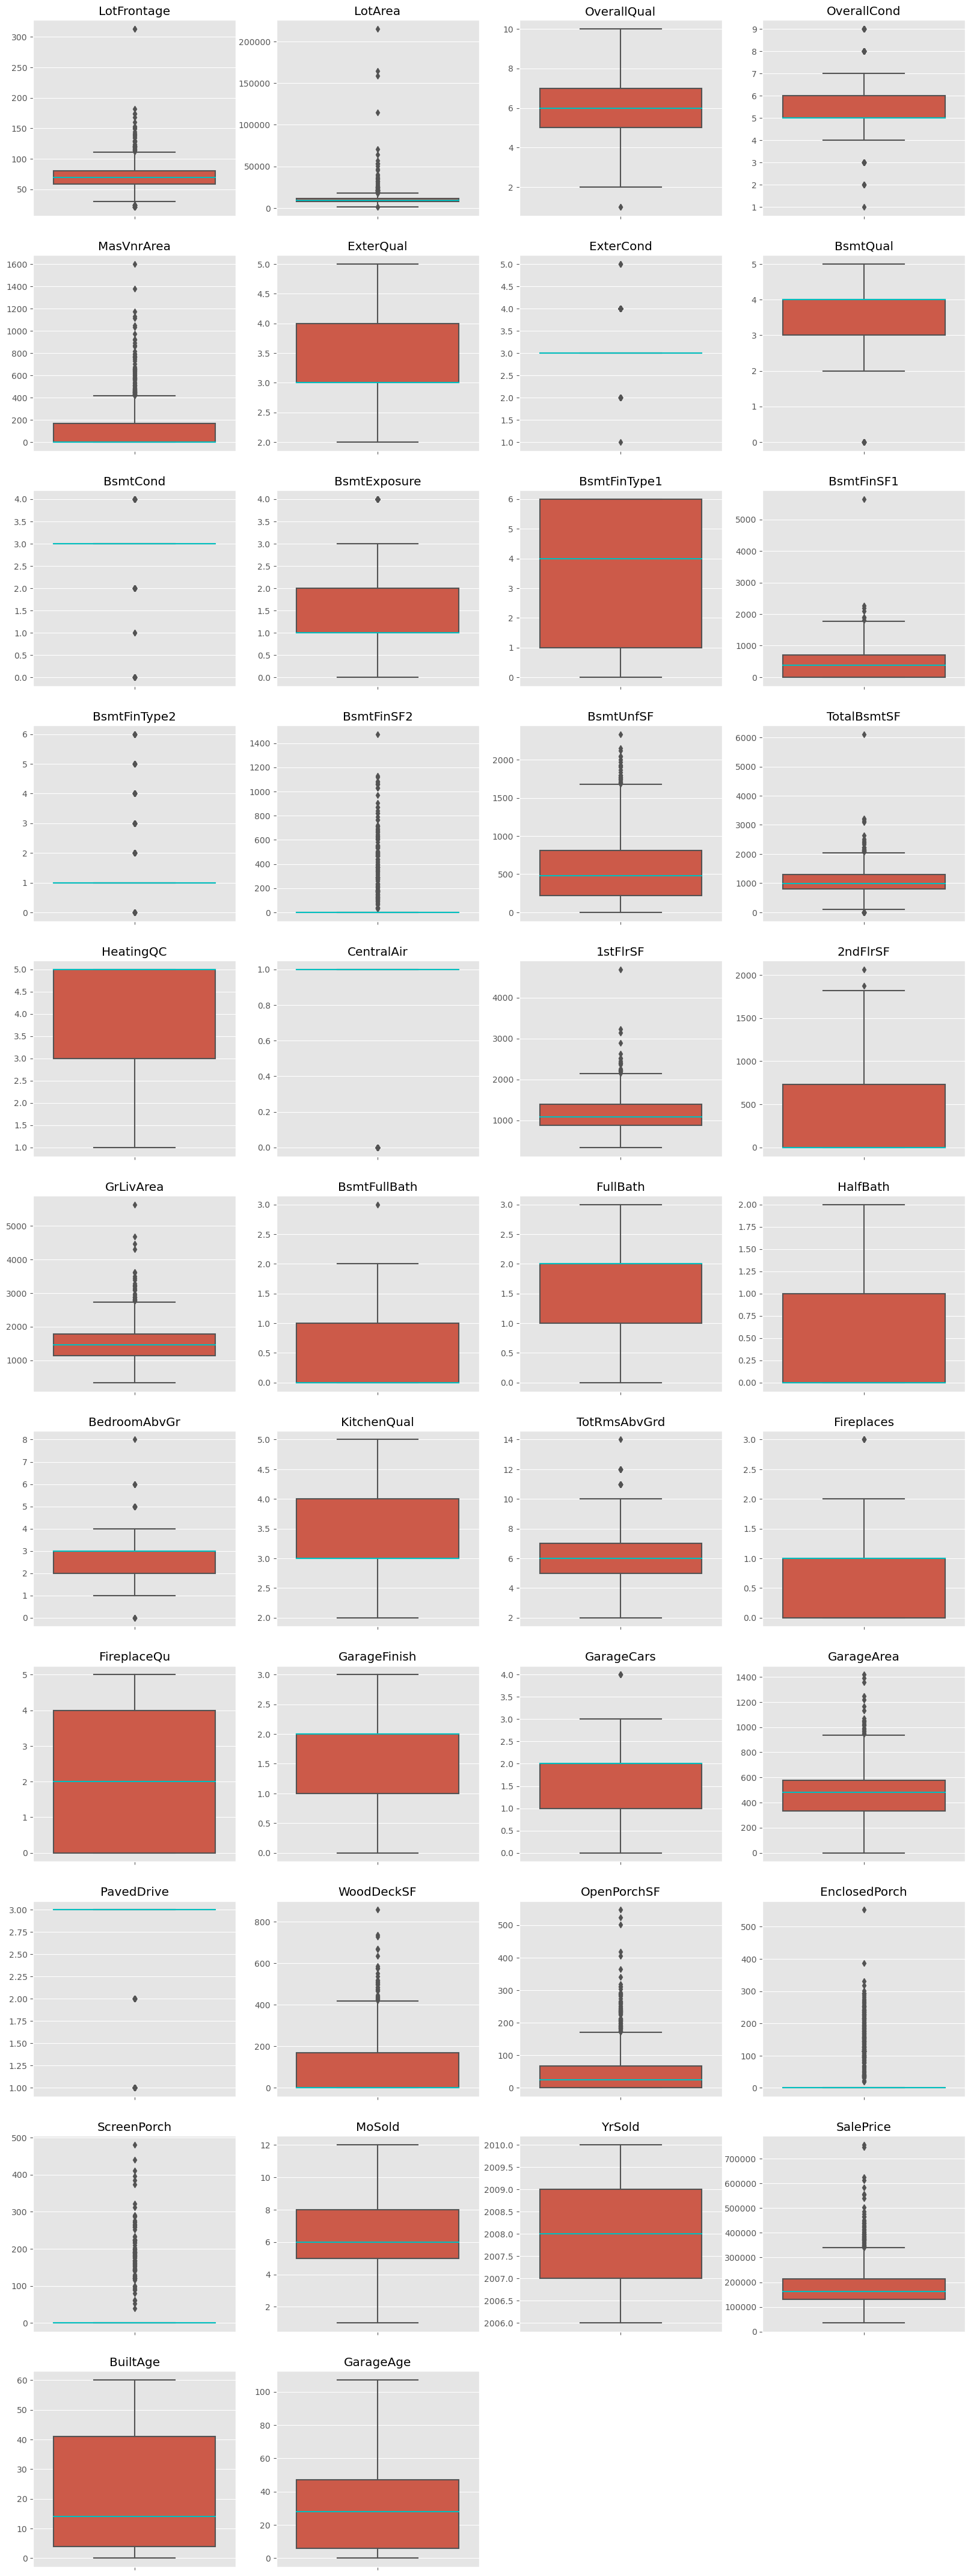

In [19]:
def plot_box(df,var):
    bw=(df[var].max()-df[var].min())/20
    g = sns.boxplot(y = var, data = df, medianprops={'color':'c'})
    g.set(xlabel="",ylabel="")
    g.set_title('{}'.format(var))
    
def BoxViz(df,num_list):
    ncol=4
    plt.figure(figsize = [20, int(np.ceil(len(num_list)/ncol))*5]) 
    plt.tight_layout()    

    for i in range(len(num_list)):
        plt.subplot(int(np.ceil(len(num_list)/ncol)),ncol,i+1)
        plot_box(df,num_list[i])

    plt.show()
    
BoxViz(df_drop[list_numerical],list_numerical)

**Comments:** We can obtain some facts for the numerical variables by comparing their distributions. Some examples are given below.

 * Most of our variables do not have normal distribution.
 * We have outliers in some variables such as ground living area square feet(GrLivArea). We will remove outliers at the end of this section. 
 * "Functional" variable seems sparse. We can remove it manually or use a feature elimination method.

### Skewness Check 

Skewness is required to see the importance of transformation which we will implement in "Preprocess the data" step. It is just a quick check.

In [20]:
# we may use boxcox transformation for variables having above 0.75 skewness(highly skewed)
skew_dict = {}
for i in list_numerical:
    skew_dict[i] = skew(df_drop[i].dropna())
df_skew = pd.DataFrame.from_dict(skew_dict, orient='index', columns=["skewness"]).sort_values("skewness", ascending=False)
print(f"Number of numerical variables: {df_skew.shape[0]} and Number of highly skewed variables: {df_skew.abs().query('skewness > 0.75').shape[0]}")
df_skew.abs().sort_values("skewness", ascending=False).head(5)

Number of numerical variables: 42 and Number of highly skewed variables: 23


,skewness
LotArea,12.195142
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtCond,3.697230
CentralAir,3.526757


### Multivariate Analysis - EDA

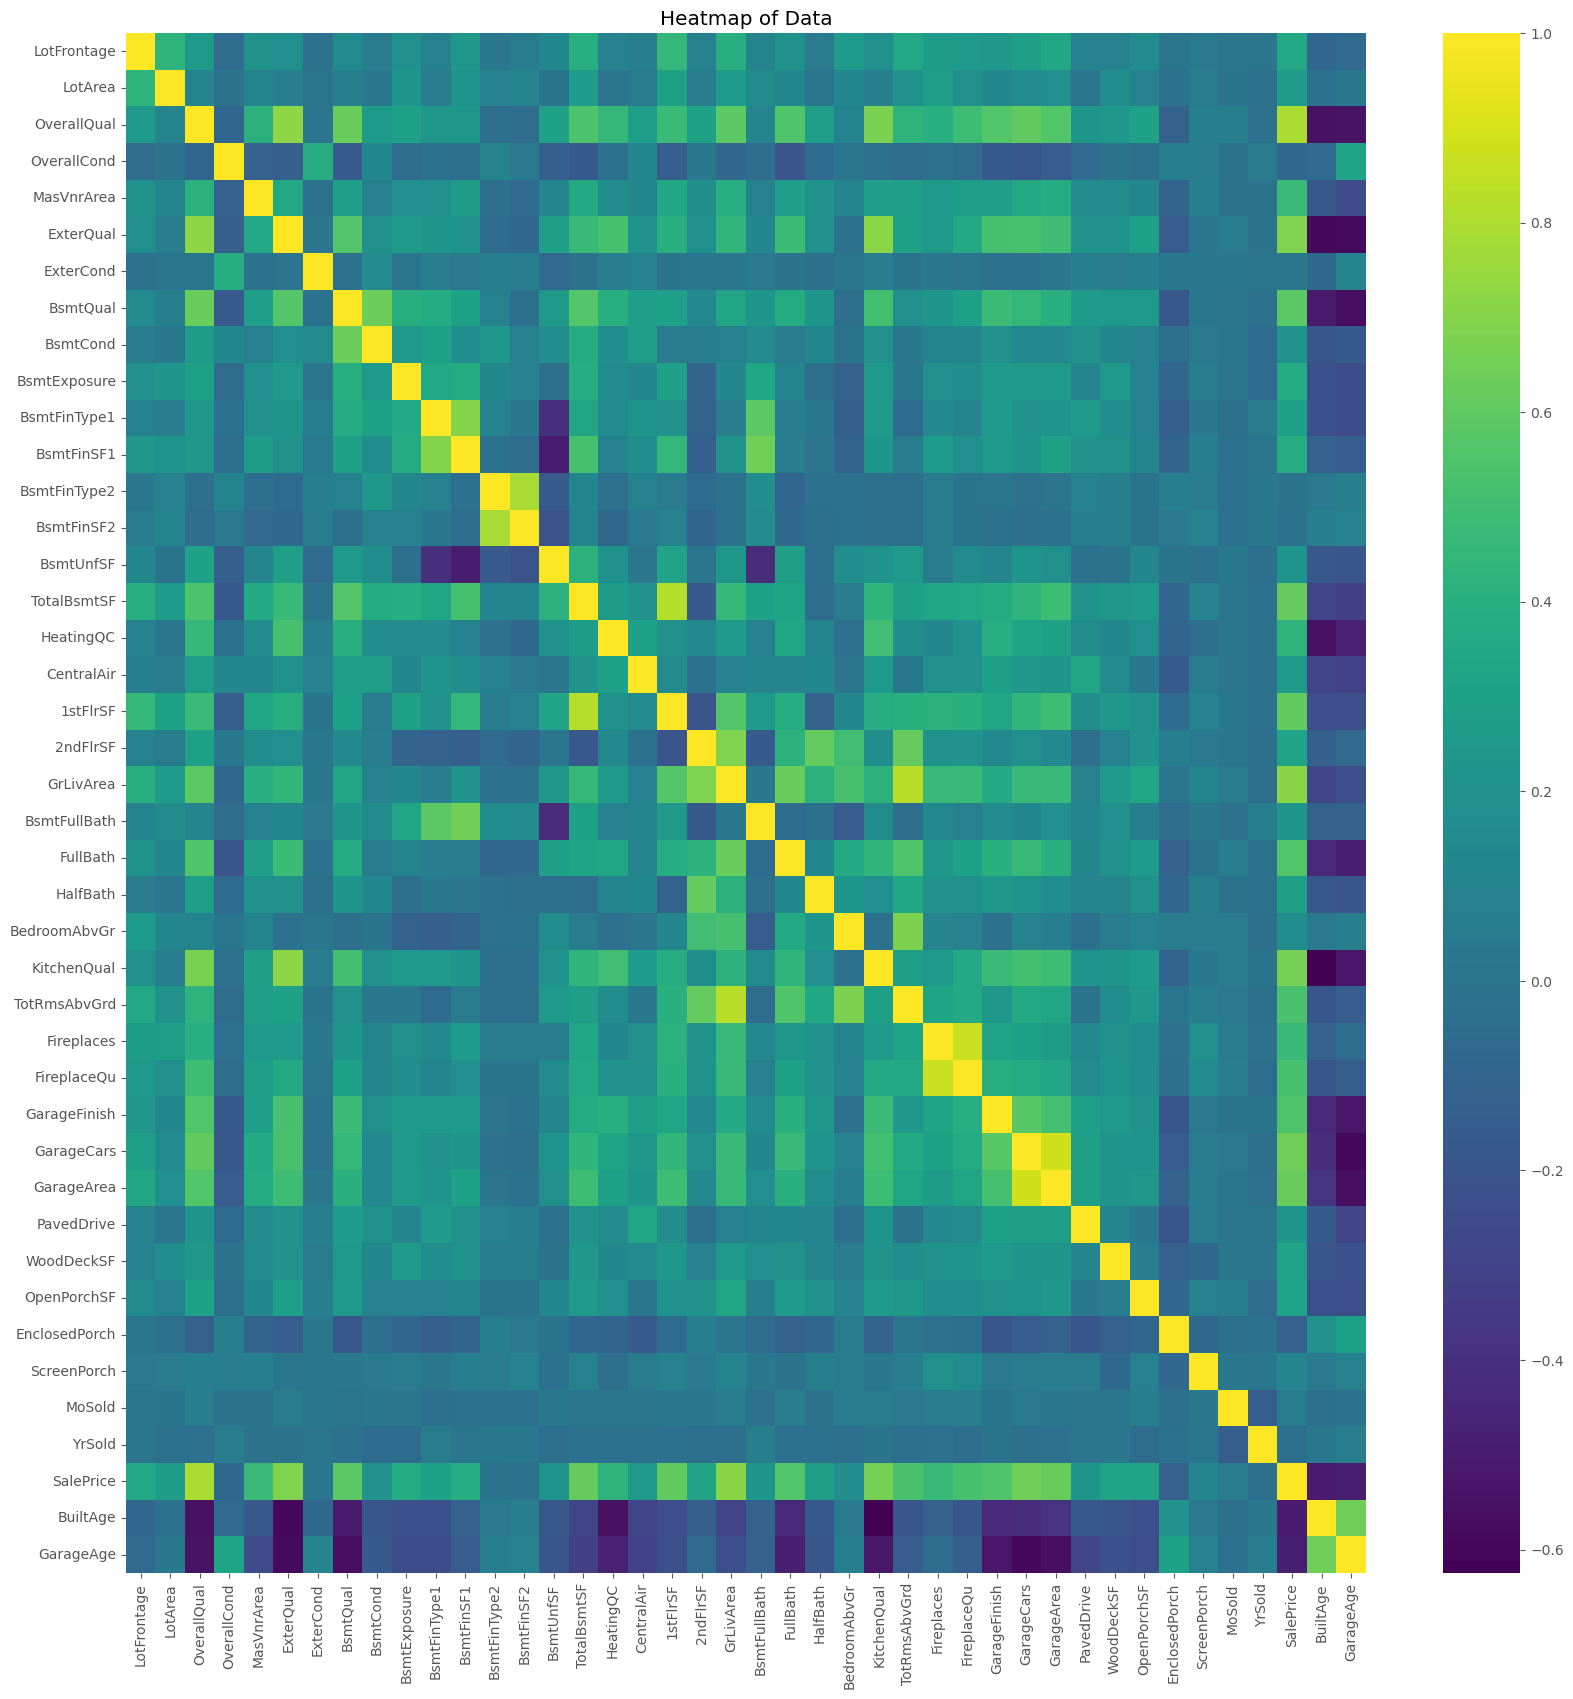

In [21]:
plt.figure(figsize=(20,20))
sns.heatmap(df_drop[list_numerical].corr(), cmap="viridis")
plt.title("Heatmap of Data")
plt.show()

In [22]:
#SalePrice pearson corr rates
round(df_drop[list_numerical].corr()['SalePrice'].abs().sort_values(ascending=False),2).to_frame().iloc[1:6,:]

,SalePrice
OverallQual,0.79
GrLivArea,0.71
ExterQual,0.68
KitchenQual,0.66
GarageCars,0.64


**Comments:** Collinearity is an another issue for Machine Learning Algorithms, especially for parametric ones. For example, Garage Age is related to the Overall Condition of the house. We could handle the collinearity by using dimensionality reduction methods such as PCA. We will let the model handle. 

We have also listed the most related variables to the target above and they make sense. For example, overall quality is of course a key factor for the sale price. 

### Bivariate Analysis - EDA

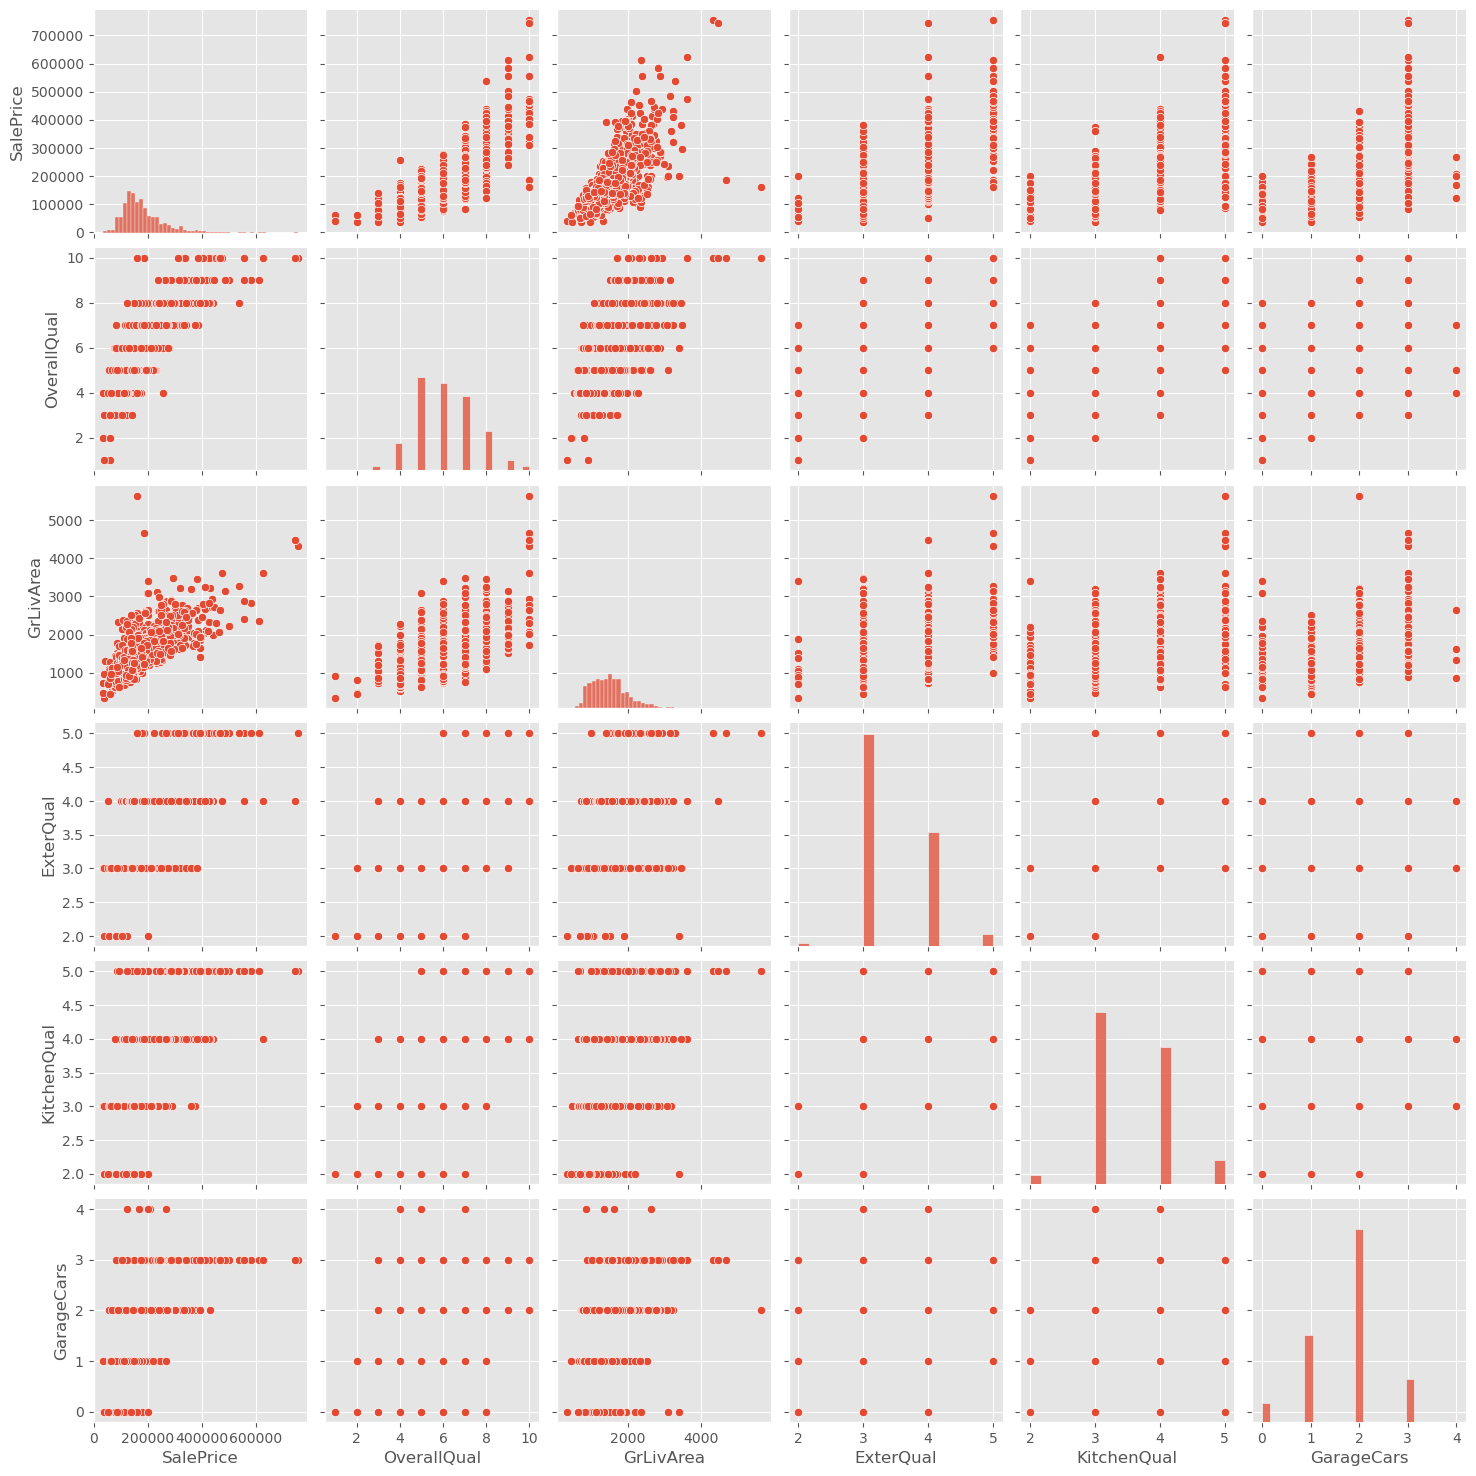

In [23]:
# Since we have many numerical variables, it does not give properly. We can have look on the most correlated variables.
corr_top5_list = df_drop[list_numerical].corr()['SalePrice'].abs().sort_values(ascending=False).to_frame().iloc[0:6,:].index
sns.pairplot(df_drop[corr_top5_list])
plt.show()

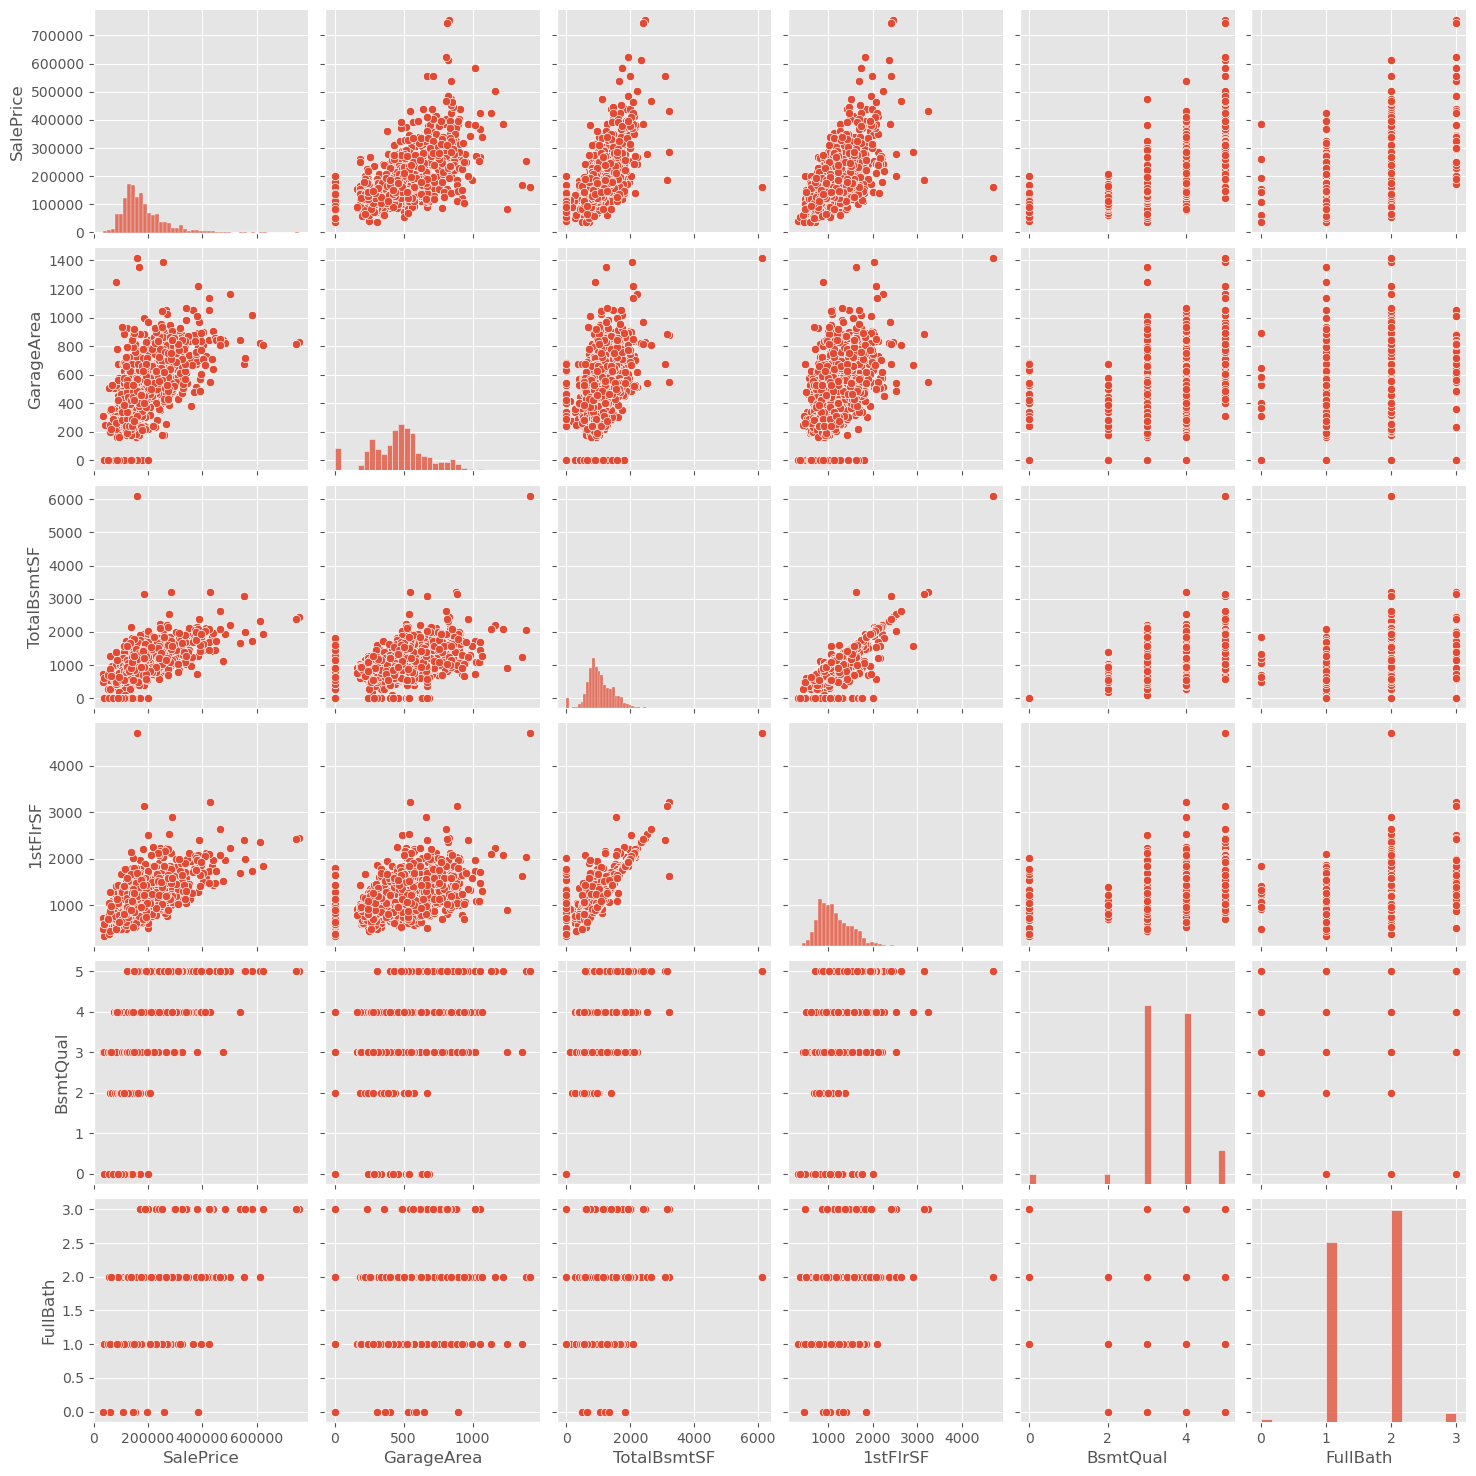

In [24]:
corr_top10_list = df_drop[list_numerical].corr()['SalePrice'].abs().sort_values(ascending=False).to_frame().iloc[[0,6,7,8,9,10],:].index
sns.pairplot(df_drop[corr_top10_list])
plt.show()

**Comments:** we can find some outliers and remove them manually.
 * GrLivArea has some outliers above 4000.
 * TotalBsmtSF has a outlier above 6000.
 * 1stFlrSF has a outlier above 4000. (same points with GrLivArea)
 
Moreover, it seems 1stFlrSF and TotalBsmtSF are correlated. 

In [25]:
# Before Preprocessing, lets perform what we have noted about target transformation and outliers so far.

def preprocess2(df):
    # target transformation
    df["SalePrice"] = np.log1p(df["SalePrice"])
    
    #outliers
    df = df.query('GrLivArea < 4000')
    df = df.query('TotalBsmtSF < 6000')
    
    return df

print(f'Dataframe shape before preprocess2: {df_drop.shape}')
df_drop = preprocess2(df_drop)
print(f'Dataframe shape after preprocess2: {df_drop.shape}')

Dataframe shape before preprocess2: (1460, 62)
Dataframe shape after preprocess2: (1456, 62)


# 3) Preprocess the data

We had an initial preprocessing at the beginning by considering the competition description. Now lets prepare the data for ML algorithms. In this step, we will create a column transformer and our strategy is here:

 * **Missing Values:** The most frequent class(mode) for categorical variables and iterative imputer with Random Forest for numerical variables will be used. Iterative imputer is chosen because instead of filling with a constant value, getting help from a regressor (RF) is preferable(It is also optional). Why did we use Random Forest? because tree-based models are not sensitive for the scaling of the variables. Therefore, if you want to implement iterative imputer with KNN, it is suggested to perform scaling first. <br>
 * **One Hot Encoding:** Since categorical variables can not be directly used in many models, we will use one hot encoding for nominal variables (not ordinal ones!). If you have issues with computation power, you have to reduce the number of variables of your dataset. In that manner, we perform 2 things: 1) translate ordinal variables into numerical ones 2) reduce the number of subcategories/classes by using variance based feature selection or cutoff function. Both of them are optional if you have high computation power, but they also affect the bias in the data. <br>
 * **Scaling:** It is not necessary for tree-based models, however it is a recommended step. Therefore, the Logarithmic transformation is used. (I also tried BoxCox and Power transformation to see the results) <br>
 
**One more note:** some tree-based models like CatBoost have its own one hot encoding(OHE) functions. So, instead of OHE in this step, you can use functions supported by models.
 

In [26]:
# Train Test Datasets
X = df_drop.drop("SalePrice", axis=1)
y = df_drop["SalePrice"]

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.20, random_state=1234)
print(f'Xtrain shape: {Xtrain.shape}, ytrain shape: {ytrain.shape}')
print(f'Xval shape: {Xval.shape}, yval shape: {yval.shape}')

Xtrain shape: (1164, 61), ytrain shape: (1164,)
Xval shape: (292, 61), yval shape: (292,)


In [27]:
# Getting indices for the transformations
categorical_var = Xtrain.select_dtypes(include="object").columns.to_list()
cat_index_list = Xtrain.columns.to_frame(index=False,name="variables").query('variables in @categorical_var').index.to_list()

# Transformers for categorical values
cat_pipe = Pipeline([('imputer_frequent', SimpleImputer(strategy="most_frequent")),
                     ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False))])

# Transformers for numerical values
num_pipe = Pipeline([('iterative impute', IterativeImputer(estimator=RandomForestRegressor(n_estimators=200), max_iter=20, tol=0.01)), 
                     ('log_trans', FunctionTransformer(np.log1p, validate=True))
                     ])

ct = ColumnTransformer([('cat_pipe',cat_pipe,cat_index_list)], 
                       remainder=num_pipe)#num_pipe

Xtrain_transformed = pd.DataFrame(ct.fit_transform(Xtrain)) 
Xval_transformed = pd.DataFrame(ct.transform(Xval))

In [28]:
print(f'Xtrain shape: {Xtrain_transformed.shape}, ytrain shape: {ytrain.shape}')
print(f'Xval shape: {Xval_transformed.shape}, yval shape: {yval.shape}')

Xtrain shape: (1164, 207), ytrain shape: (1164,)
Xval shape: (292, 207), yval shape: (292,)


### Variance-based Feature Selection

We have 1164 X 207 dimension for our training dataset. Such high dimensional data can cause some problems for ML algorithms, so feature selection is needed. 

In [29]:
# Since we have some near-zero variance variables, we can eliminate them by using VarianceThreshold 
from sklearn.feature_selection import VarianceThreshold #variance based selection
vt = VarianceThreshold(threshold=0.05)
Xtrain_transformed = vt.fit_transform(Xtrain_transformed)
Xval_transformed = vt.transform(Xval_transformed)

print(f'Xtrain shape: {Xtrain_transformed.shape}, ytrain shape: {ytrain.shape}')
print(f'Xval shape: {Xval_transformed.shape}, yval shape: {yval.shape}')

Xtrain shape: (1164, 86), ytrain shape: (1164,)
Xval shape: (292, 86), yval shape: (292,)


# 4) Model Selection and Hyperparameter Search

After the Preprocessing Step, our dataset is ready for modeling! Let's calculate the baseline scores for our models and evaluate the results. The evaluation metric is stated in the competition description as RMSE, but Mean Absolute Error(MAE) and Mean Absolute Percent Error (MAPE) are also used.

In [30]:
# For baseline RMSE
def evaluationMetrics(clf,Xtrain,Xval,ytrain,yval,refit=True):
    
    dict_output= {}
    
    if refit:
        clf.fit(Xtrain,ytrain)
    ytrainPred=np.expm1(clf.predict(Xtrain))
    ytestPred=np.expm1(clf.predict(Xval))
    ytrain = np.expm1(ytrain)
    yval = np.expm1(yval)
    
    #Metrics
    dict_output["reg_name"]=type(clf).__name__
    dict_output["train_RMSE"]=mean_squared_error(ytrain,ytrainPred, squared=False)
    dict_output["test_RMSE"]=mean_squared_error(yval,ytestPred, squared=False)
    dict_output["train_MAE"]=mean_absolute_error(ytrain,ytrainPred)
    dict_output["test_MAE"]=mean_absolute_error(yval,ytestPred)
    dict_output["train_MAPE"]=mean_absolute_percentage_error(ytrain,ytrainPred)
    dict_output["test_MAPE"]=mean_absolute_percentage_error(yval,ytestPred)
    

    return dict_output

# For visualization of the metric results
def evaluationPlots(df):
    ncol=2
    nrow=(df.shape[1]-1)//2

    fig, axs = plt.subplots(nrow,ncol, figsize=(12,12), sharex=True)
    axs=axs.flatten()
    ax=0
    for i in range(1,df.shape[1]):
        g = sns.barplot(data=df, x=df.iloc[:,0], y=df.iloc[:,i], ax=axs[ax])
        ax+=1
        
        if df.columns[i].find("MAPE") !=-1: # for percentage results
            for p in g.patches:
                values = p.get_height()
                x = p.get_x() + p.get_width()/2
                y = p.get_height() *0.5
                g.annotate(f'{values:.2%}', (x, y),ha='center', size='medium', color='darkred', weight='semibold', rotation=90)

        else:
            for p in g.patches:
                values = round(p.get_height(),0)
                x = p.get_x() + p.get_width()/2
                y = p.get_height() *0.5
                g.annotate(f'{values:,}', (x, y),ha='center', size='medium', color='darkred', weight='semibold', rotation=90)

    axs[-2].set_xticks(axs[-2].get_xticks(), axs[-2].get_xticklabels(), rotation=90)
    axs[-1].set_xticks(axs[-1].get_xticks(), axs[-1].get_xticklabels(), rotation=90)
    
    # Want to shareY axis for the same metrics.
    for i in np.array(range(nrow))*2:
        axs[i].sharey(axs[i+1])
    
    plt.tight_layout()
    plt.show()

/var/folders/2c/k6r12c3d4jjcdrmrlsr5bn8h0000gn/T/ipykernel_1425/1459320842.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_eval=df_eval.append(evaluationMetrics(reg_list[i],Xtrain_transformed,Xval_transformed,ytrain,yval),
/var/folders/2c/k6r12c3d4jjcdrmrlsr5bn8h0000gn/T/ipykernel_1425/1459320842.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_eval=df_eval.append(evaluationMetrics(reg_list[i],Xtrain_transformed,Xval_transformed,ytrain,yval),
/var/folders/2c/k6r12c3d4jjcdrmrlsr5bn8h0000gn/T/ipykernel_1425/1459320842.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_eval=df_eval.append(evaluationMetrics(reg_list[i],Xtrain_transformed,Xval_transformed,ytrain,yval),
/var/folders/2c/k6r12c3d4jjcdrmrlsr5bn8h

,reg_name,train_RMSE,test_RMSE,train_MAE,test_MAE,train_MAPE,test_MAPE
0,RandomForestRegressor,11178.839270,26538.715162,6940.441885,17648.155743,0.038868,0.110768
1,GradientBoostingRegressor,13532.186258,23210.902296,9591.198959,16389.011917,0.055472,0.106409
2,XGBRegressor,231.793246,25322.803054,151.967894,17728.987184,0.000869,0.114113
3,LGBMRegressor,3524.202430,24913.045174,2274.644847,17082.811079,0.013018,0.109601
4,CatBoostRegressor,9929.572495,23804.133364,7206.005739,16203.259995,0.040980,0.103201


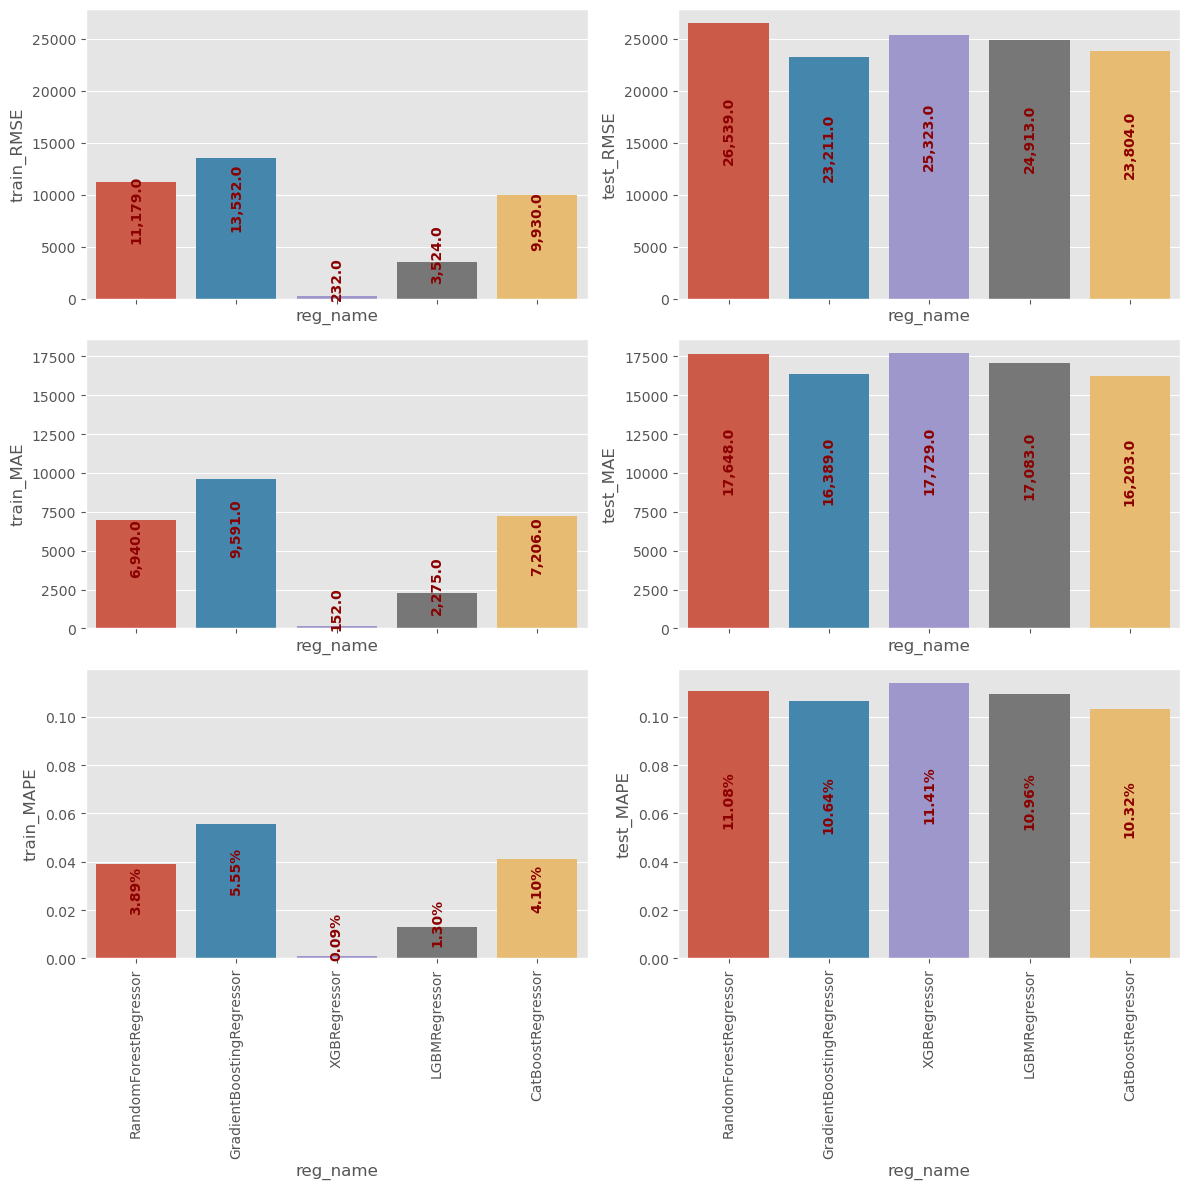

In [31]:
# Regressors
reg_list=[RandomForestRegressor(n_estimators = 200),
          GradientBoostingRegressor(n_estimators = 200),
          XGBRegressor(n_estimators = 200),
          LGBMRegressor(n_estimators = 200), 
          CatBoostRegressor(n_estimators = 200, verbose=False)
          ]

for i in range(len(reg_list)):
    if i == 0:
        df_eval=pd.DataFrame(evaluationMetrics(reg_list[i],Xtrain_transformed,Xval_transformed,ytrain,yval),index=[0])
    else:
        df_eval=df_eval.append(evaluationMetrics(reg_list[i],Xtrain_transformed,Xval_transformed,ytrain,yval), 
                               ignore_index=True)

display(df_eval)
evaluationPlots(df_eval)


**Comments:** 
 * When we compare the train and test results, it is obvious that we have overfitting issues.
 * MAPE test results are around 10% while train ones are around 3-4%.
 * The top performers are CatBoost and XGB and hyperparameter search is needed to improve their performances.

### Hyperparameter search for Catboost and XGB

By hyperparameter search, we can optimize our selected models to increase our evaluation metrics. In that manner, documentations of the models should be checked to see the important parameters and notes. 


**XGB:** https://xgboost.readthedocs.io/en/stable/parameter.html <br>
**CatBoost:** https://catboost.ai/en/docs/concepts/python-reference_catboostregressor

In [32]:
def evaluationResult(name,ytrain,yval,yhat_train,yhat):
    
    # log1p reverse transform
    ytrain = np.expm1(ytrain)
    yval = np.expm1(yval)
    yhat_train = np.expm1(yhat_train)
    yhat = np.expm1(yhat)
    
    # results
    dict_hyper_output = {}
    dict_hyper_output["reg_name"]=name
    dict_hyper_output["train_RMSE"]=mean_squared_error(ytrain,yhat_train, squared=False)
    dict_hyper_output["test_RMSE"]=mean_squared_error(yval,yhat, squared=False)
    dict_hyper_output["train_MAE"]=mean_absolute_error(ytrain,yhat_train)
    dict_hyper_output["test_MAE"]=mean_absolute_error(yval,yhat)
    dict_hyper_output["train_MAPE"]=mean_absolute_percentage_error(ytrain,yhat_train)
    dict_hyper_output["test_MAPE"]=mean_absolute_percentage_error(yval,yhat)
    
    return dict_hyper_output

In [33]:
cv = KFold(n_splits=5, shuffle=True, random_state=1234)

# Hyperparameter Search for XGB
XGBParams = {"n_estimators" : [100,200,500,1000,1500],
            "learning_rate": np.linspace(0.05,0.3,50), #default=0.3   
            "min_child_weight": range(1,10,2), #default=1
            "max_depth": range(2,10,2),#default=6
            "subsample": [0.2, 0.5, 0.8, 1]}#default=1

rscv_xgb = RandomizedSearchCV(XGBRegressor(objective="reg:squarederror",early_stopping_rounds=25), XGBParams,
                          cv = cv, return_train_score = True, n_iter=50)


rscv_xgb.fit(Xtrain_transformed, ytrain, eval_set=[(Xtrain_transformed, ytrain), (Xval_transformed, yval)], verbose=False)
yhat_xgb = rscv_xgb.predict(Xval_transformed)
yhat_train_xgb = rscv_xgb.predict(Xtrain_transformed)

print("Best n_estimators:", rscv_xgb.best_estimator_.n_estimators)
print("Best learning_rate:", rscv_xgb.best_estimator_.learning_rate)
print("Best min_child_weight:", rscv_xgb.best_estimator_.min_child_weight)
print("Best max_depth:", rscv_xgb.best_estimator_.max_depth)
print("Best subsample:", rscv_xgb.best_estimator_.subsample)

df_eval_hyper=pd.DataFrame(evaluationResult("XGBRegressor_hyper",ytrain,yval,yhat_train_xgb,yhat_xgb),index=[0])
display(df_eval_hyper)

Best n_estimators: 1000
Best learning_rate: 0.12653061224489795
Best min_child_weight: 9
Best max_depth: 2
Best subsample: 1


,reg_name,train_RMSE,test_RMSE,train_MAE,test_MAE,train_MAPE,test_MAPE
0,XGBRegressor_hyper,17117.572611,23606.257154,12002.045707,16188.07256,0.070898,0.10417


In [ ]:
# Hyperparameter Search for CatBoost
CatParams = {"iterations" : [200, 500, 1000, 2000],#default=1000
            "learning_rate": [0.01, 0.015, 0.020, 0.025, 0.03],#default=0.03
            "depth": range(6,11,2), #default=6 
            "l2_leaf_reg": range(3,13,3) #default=3
            }

rscv_catb = RandomizedSearchCV(CatBoostRegressor(logging_level = "Silent", loss_function="RMSE", early_stopping_rounds=25), CatParams,
                          cv = cv, return_train_score = True, n_iter=10) # you can increase n_iter for better results


rscv_catb.fit(Xtrain_transformed, ytrain, eval_set=[(Xtrain_transformed, ytrain), (Xval_transformed, yval)])
yhat_catb = rscv_catb.predict(Xval_transformed)
yhat_train_catb = rscv_catb.predict(Xtrain_transformed)

print("Best iterations:", rscv_catb.best_estimator_.get_param('iterations'))
print("Best learning_rate:", rscv_catb.best_estimator_.get_param('learning_rate'))
print("Best depth:", rscv_catb.best_estimator_.get_param('depth'))
print("Best l2_leaf_reg:", rscv_catb.best_estimator_.get_param('l2_leaf_reg'))

# Metrics
df_eval_hyper=df_eval_hyper.append(evaluationResult("CatBoostRegressor_hyper",ytrain,yval,yhat_train_catb,yhat_catb), ignore_index=True)
display(df_eval_hyper)

In [ ]:
eval_result = pd.concat([df_eval.query('reg_name in ["XGBRegressor", "CatBoostRegressor"]'), df_eval_hyper])
evaluationPlots(eval_result.sort_values("reg_name", ascending=False))

**Comments:** We have little improvements for both regressor after hyperparameter search. Since CatBoost results are better, we can predict the test data set and submit the results :) 

The results can differ for each run since hyperparameter search is random. If you want you can also save the model after hyperparameter search or set a seed.

Also, LGBM is a challenger one, you can also optimize it if you want as a practice or shameless self promotion ;)

# 5) Final Prediction and Export

In [ ]:
# Preprocess for test 
df_test2 = preprocess1(df_test) # our initial process step
Xtest_transformed = pd.DataFrame(ct.transform(df_test2)) # our column transformer step
Xtest_transformed = vt.transform(Xtest_transformed) # our variance based feature selection step
# Test prediction with our model.
ytest_hat = rscv_catb.predict(Xtest_transformed) #rscv_xgb rscv_catb
# Reverse the logarithmic transformation for the final results
ytest_hat_reverse = np.expm1(ytest_hat)
ytest_hat_reverse

In [ ]:
# Submission
df_tmp = df_test[["Id"]]
df_final = df_tmp.merge(pd.DataFrame(ytest_hat_reverse), left_index=True, right_index=True)
df_final=df_final.rename(columns={0:"SalePrice"}).set_index("Id")#.to_csv("submission.csv")
df_final.head()

# 6) Additional: Averaging Models

So we have 2 optimized models, why dont we average them to get new results. Stacking models is a good approach and may increase your evaluation metrics. You can also add a new model/learner on the top of our models' results and predict new results. 

If you are interested in stacking models, check here:
https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

In [ ]:
stack_train=np.column_stack([yhat_train_catb,yhat_train_xgb])
prediction_mean_train = np.mean(stack_train, axis=1)

stack_val = np.column_stack([yhat_catb,yhat_xgb])
prediction_mean_val = np.mean(stack_val, axis=1)

# Metrics
df_eval_hyper=df_eval_hyper.append(evaluationResult("StackedModel",ytrain,yval,prediction_mean_train,prediction_mean_val), ignore_index=True)
display(df_eval_hyper)

eval_result_final = pd.concat([df_eval.query('reg_name in ["XGBRegressor", "CatBoostRegressor"]'), df_eval_hyper])
evaluationPlots(eval_result_final.sort_values("reg_name", ascending=False))

In [ ]:
# Preprocess for test 
df_test2 = preprocess1(df_test)
Xtest_transformed = pd.DataFrame(ct.transform(df_test2))
Xtest_transformed = vt.transform(Xtest_transformed)
# Test prediction with our model.
ytest_hat_catb = rscv_catb.predict(Xtest_transformed)
ytest_hat_xgb = rscv_xgb.predict(Xtest_transformed)

# get the mean of the models
stack_test=np.column_stack([ytest_hat_catb,ytest_hat_xgb])
prediction_mean_test = np.mean(stack_test, axis=1)

ytest_hat_mean_reverse = np.expm1(prediction_mean_test)
ytest_hat_mean_reverse

In [ ]:
# Submission
df_tmp = df_test[["Id"]]
df_final = df_tmp.merge(pd.DataFrame(ytest_hat_mean_reverse), left_index=True, right_index=True)
#df_final=df_final.rename(columns={0:"SalePrice"}).set_index("Id").to_csv("submission.csv")

If you found this notebook helpful, some upvotes would be very much appreciated! :) 